In [1]:
import numpy as np
import pandas as pd
from scipy.stats import laplace
import scipy.stats
import psycopg2
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from datetime import datetime
from datetime import timedelta  
import threading
import os

In [2]:
param_dic = {
    "host"      : "localhost",
    "database"  : "bachelorBesoeg2014",
    "user"      : "postgres",
    "password"  : "password",
    "port"      : "5432"
}

def execRangeQuery(params_dic,dates):
    query = """
    SELECT
    sum(count_)
    FROM _775147
    WHERE
    time_ >= '{date0}'
    AND time_ <=  '{date1}'
    ;
    """.format(date0 = dates[0], date1 = dates[1])
    try:
        connection = psycopg2.connect(**params_dic)
        cursor = connection.cursor()
        cursor.execute(query)
        record = cursor.fetchall()
        return record
    except (Exception, psycopg2.Error) as error :
        connection = False
        print ("Error while connecting to PostgreSQL", error)
    finally:
        if(connection):
            cursor.close()
            connection.close()
            print("Executed query and closed connection.")

def execQuery(params_dic,query):
    try:
        connection = psycopg2.connect(**params_dic)
        cursor = connection.cursor()
        cursor.execute(query)
        record = cursor.fetchall()
        return record
    except (Exception, psycopg2.Error) as error :
        connection = False
        print ("Error while connecting to PostgreSQL", error)
    finally:
        if(connection):
            cursor.close()
            connection.close()
            print("Executed query and closed connection.")
#"""select count(*) as number_of_dates, count(DISTINCT  count_) as distinct_count from _775147;"""
query = """select time_ from _775147;"""
result = execQuery(param_dic, query)
dates = [(date[0]) for date in result]

query = """select count_ from _775147;"""
result = execQuery(param_dic, query)
"""
print(result)
print(type(result))
print(type(result[0]))
print((str(result[0][0])))
"""
counts = [(count[0]) for count in result]

Executed query and closed connection.
Executed query and closed connection.


In [3]:
def add_missing_dates(old_dates):
    start_date = dates[0]
    end_date = dates[-1]
    all_dates = pd.date_range(start = start_date, end = end_date).to_pydatetime().tolist()
    return [(date.date()) for date in all_dates]
    
def add_missing_counts(old_counts, old_dates, new_dates):
        """Adds 0 to the list of counts where there was missing dates
        Parameters:
        old_counts (list of int): List counts for each day with 
        old_dates (list of datetime.date): List of dates that is not countious
        Returns:
        List of countious starting with the first value of 
        """
        zip_iterator = zip(old_dates, old_counts)
        missing_dict =  dict(zip_iterator)
        all_counts = np.zeros(len(new_dates))
        for i, date in enumerate(new_dates):
            val = missing_dict.get(date, 0)
            all_counts[i] = val
            
        return all_counts

In [4]:
all_dates = add_missing_dates(dates)
all_counts =  add_missing_counts(counts, dates, all_dates)

In [5]:
np.random.uniform(-1,0,1000)
def randomized_response(x, p=0.1):
    if np.random.uniform(0,1) < p:
        return x
    else:
        return np.random.randint(2)

In [7]:
randomized_response(1)

1

In [8]:

"""
def left_or_right(current, nxt):
    #0 is left 1 is right
    #print(f'current = {current}, nxt = {nxt}')
    if nxt == 0:
        #print('nxt == 0')
        return 0
    if current == 0 and current < nxt:
        #print('current == 0 and current < nxt')
        return 1
    elif 2* current < nxt:
        #print('2* current < nxt')
        return 1
    else:
        #print('else')
        return 0
    
def left_or_right_list(path):
    #print(path)
    #0 is left 1 is right
    direction_lst = []
    for i in range(len(path)-1):
        #print(f'i = {i}')
        current = path[i]
        nxt = path[i+1]
        #print(f'current = {current}, nxt = {nxt}')
        if nxt == 0:
            #print('nxt == 0')
            direction_lst.append(0)
        elif current == 0 and current < nxt:
            #print('current == 0 and current < nxt')
            direction_lst.append(1)
        elif 2* current < nxt:
            #print('2* current < nxt')
            direction_lst.append(1)
        else:
            #print('else')            
            direction_lst.append(0)
            
    return direction_lst
"""

"\ndef left_or_right(current, nxt):\n    #0 is left 1 is right\n    #print(f'current = {current}, nxt = {nxt}')\n    if nxt == 0:\n        #print('nxt == 0')\n        return 0\n    if current == 0 and current < nxt:\n        #print('current == 0 and current < nxt')\n        return 1\n    elif 2* current < nxt:\n        #print('2* current < nxt')\n        return 1\n    else:\n        #print('else')\n        return 0\n    \ndef left_or_right_list(path):\n    #print(path)\n    #0 is left 1 is right\n    direction_lst = []\n    for i in range(len(path)-1):\n        #print(f'i = {i}')\n        current = path[i]\n        nxt = path[i+1]\n        #print(f'current = {current}, nxt = {nxt}')\n        if nxt == 0:\n            #print('nxt == 0')\n            direction_lst.append(0)\n        elif current == 0 and current < nxt:\n            #print('current == 0 and current < nxt')\n            direction_lst.append(1)\n        elif 2* current < nxt:\n            #print('2* current < nxt')\n       

In [9]:
def HH_OUE(dates, counts, OUE, epsilon):
    h = int(np.ceil(np.log2(len(dates))))
    prob = np.full(h+1,1/(h+1))
    print(f'h = {h}')
    
    tree_levels = []
    for i in np.arange(0,h+1):
        level = np.zeros(int(2**np.ceil(i)))
        tree_levels.append(level) 
    
    #OUE response
    vfunc = np.vectorize(OUE, otypes = [int])
    
    
    for index, (date, day_count) in enumerate(zip(dates, counts)):
        #print(f'index = {index}, date = {date}, count = {day_count}')
        idxs = get_index(index,h)
        idxs.reverse()
        
        for person in range(int(day_count)):
            #print(person)
            level = np.random.choice(np.arange(0, h+1), p = prob ) 
            #print(f'we got level = {level}')
            tree_level = np.zeros(2**level,dtype=int)
            #print(idxs[level])
            #tree_level[index] = 1
            #get_index
            tree_level[idxs[level]] = 1
            perb_tree_level = vfunc(tree_level,epsilon)
            tree_levels[level] = tree_levels[level] + perb_tree_level
        #print(f'index = {index}, date = {type(date)}, count = {count}')
        #print(index, value1 + value2)  # for Python 2 use: `print index, value1 + value2` (no braces)
    return tree_levels

In [12]:
class HH_OLH_cc:
    def __init__(self, epsilon, dates, counts):
        """Setup of the datastructere
        Parameters:
        T (int): The lenght of the stream
        epsilon (float): The height of the full binary tree. 
        dates (Array): The dates of the stream
        counts (Array): The count for each of the dates
        Returns:
        A epsilon differintial datastructe
        """
        self.epsilon = epsilon
        self.all_dates = dates
        self.all_counts = counts
        if len(dates) < (dates[-1]-dates[0]).days:
            print('here')
            self.all_dates = self.__add_missing_dates(dates)
            self.all_counts = self.__add_missing_counts(counts,dates)
            
        #Make dict for date indexing
        values = np.arange(0,len(self.all_dates))
        zip_iterator = zip(self.all_dates, values)
        self.idx_dict =  dict(zip_iterator)
        
        self.h = int(np.ceil(np.log2(len(self.all_dates))))
        self.level_prob = np.full(self.h+1,1/(self.h+1))
    
        self.tree_levels = self.__process(self.all_dates, self.all_counts)
        #Check if we are we have missing dates.
        
    def __add_missing_dates(self, old_dates):
        """Add missing dates in a list
        Parameters:
        old_dates (list of datetime.date): List of dates that is not countious
        Returns:
        List of countious starting with the first value of 
        """
        start_date = dates[0]
        end_date = dates[-1]
        all_dates = pd.date_range(start = start_date, end = end_date).to_pydatetime().tolist()
        return [(date.date()) for date in all_dates]
    
    def __add_missing_counts(self, old_counts, old_dates):
        """Adds 0 to the list of counts where there was missing dates
        Parameters:
        old_counts (list of int): List counts for each day with 
        old_dates (list of datetime.date): List of dates that is not countious
        Returns:
        List of countious starting with the first value of 
        """
        zip_iterator = zip(old_dates, old_counts)
        missing_dict =  dict(zip_iterator)
        all_counts = np.zeros(len(self.dates))
        for i, date in enumerate(self.dates):
            val = missing_dict.get(date, 0)
            all_counts[i] = val
            
        return all_counts
    
    def __process(self, dates, counts):
        tree_levels = []
        for i in np.arange(0,self.h+1):
            level = np.zeros(int(2**np.ceil(i)))
            tree_levels.append(level)
        
        for index, (date, day_count) in enumerate(zip(dates, counts)):
            #print(f'index = {index}, date = {date}, count = {count}')
            idxs = self.get_index(index,self.h)
            idxs.reverse()

            for person in range(int(day_count)):
                level = np.random.choice(np.arange(0, self.h+1), p = self.level_prob ) 
                tree_level = np.zeros(2**level,dtype=int)
                
                if level != 0:
                    response = self.OLH_func(idxs[level], (2**level))
                else:
                    response = 0
                tree_levels[level][response] = tree_levels[level][response] + 1

        return tree_levels

    def get_index(self, date_idx, n_layers):
        """Calculates the path of index in full binary string

        Parameters:
        date_idx (int): The node in the bouttom layer we want to calculate a path to. 
        The bottom layer has index from 0 to 2**h-1
        n_layers (int): The height of the full binary tree. 

        Returns:
        list: of index in the path from the starting from the bottom and going up
        """
        idx = []
        for i in np.arange(0,n_layers):
            if i == 0:
                idx.append(int(date_idx))
            else:
                idx.append(int(idx[i-1]//2))
        idx.append(0)
        return idx
    
    def OLH_func(self, correct_answear, g):
        p = np.exp(self.epsilon)/(np.exp(self.epsilon)+g-1)
        if np.random.uniform(0,1) < p:
            #print('if')
            return correct_answear
        else:
            return np.random.randint(low = 0, high = g)
    
    def OLH_aggre(self, count, N, g):
        p = np.exp(self.epsilon)/(np.exp(self.epsilon)+g-1)
        #print(p - 1/g)
        #print(f'p = {p}')
        return (count - (1-p)*N/g) / (p)
    
    def answer(self, dates):
        """Calculates the path of index in full binary string

        Parameters:
        dates (tuple of string): Two dates in the format string 2000-12-19. 

        Returns:
        float: The private range count
        """
            
        date_obj_0 = datetime.strptime(dates[0],'%Y-%m-%d').date()
        date_obj_1 = datetime.strptime(dates[1],'%Y-%m-%d').date()


        idx_0 = self.idx_dict[date_obj_0]
        idx_1 = self.idx_dict[date_obj_1]

        idx_left = idx_0-1
        idx_right = idx_1+1

        path_to_left = np.flip(np.array(self.get_index(idx_left,self.h)))
        path_to_right = np.flip(np.array(self.get_index(idx_right,self.h)))

        if idx_0 == 0:
            left_or_right_list_leftside = left_or_right_list(path_to_left[path_to_right != path_to_left])
            left_or_right_list_rightside = left_or_right_list(path_to_right[path_to_right != path_to_left])
            level_offset = len(path_to_left)-len(left_or_right_list((np.array(path_to_left)[path_to_right != path_to_left])))
            
            sum_level = 0.0
            #sum_all = 0.0
            
            for i in range(len(left_or_right_list_rightside)):
                if left_or_right_list_rightside[i] == 1:
                    node = self.tree_levels[i+level_offset][path_to_right[i+level_offset]-1]
                    #print('Node')
                    #print(node)
                    #print('With all')
                    #contribution_all = self.OLH_aggre(node, np.sum(self.all_counts), len(self.all_dates))
                    #sum_all = sum_all + self.OLH_aggre(node, np.sum(self.all_counts), len(self.all_dates))
                    #print(contribution_all)
                    #print('with level')
                    contribution_level = self.OLH_aggre(node, np.sum(self.tree_levels[i+level_offset]), len(self.tree_levels[i+level_offset]))
                    sum_level = sum_level + contribution_level
                    #print(self.tree_levels[i+level_offset])
                    #print(contribution_level)
                    #print(np.sum(self.tree_levels[i+level_offset]))
                    #print(len(self.tree_levels[i+level_offset]))
                    
            #print('____________________________')
            #print(sum_level)
            #print(sum_all)
            return sum_level * (self.h+1)
            
        elif idx_1 == np.max(np.fromiter(self.idx_dict.values(), dtype = int)):
            left_or_right_list_leftside = left_or_right_list(path_to_left[path_to_right != path_to_left])
            left_or_right_list_rightside = left_or_right_list(path_to_right[path_to_right != path_to_left])
            level_offset = len(path_to_left)-len(left_or_right_list((np.array(path_to_left)[path_to_right != path_to_left])))
            
            for i in range(len(left_or_right_list_leftside)):
                if left_or_right_list_leftside[i] == 0:
                    node = self.tree_levels[i+level_offset][path_to_left[i+level_offset]+1]
                    print('Node')
                    print(node)
                    print('with level')
                    print(self.tree_levels[i+level_offset])
                    print(self.OLH_aggre(node, self.epsilon, np.sum(self.tree_levels[i+level_offset]), len(self.tree_levels[i+level_offset])))
                    
        else:
            left_or_right_list_leftside = left_or_right_list(path_to_left[path_to_right != path_to_left])
            left_or_right_list_rightside = left_or_right_list(path_to_right[path_to_right != path_to_left])

            level_offset = len(path_to_left)-len(left_or_right_list((np.array(path_to_left)[path_to_right != path_to_left])))
            
            for i in range(len(left_or_right_list_leftside)):
                if left_or_right_list_leftside[i] == 0:
                    node = self.tree_levels[i+level_offset][path_to_left[i+level_offset]+1]
                    print('Node')
                    print(node)
                    #print(self.OLH_aggre(node, self.epsilon, np.sum(self.all_counts), len(self.all_dates)))
                    print('with level')
                    print(self.tree_levels[i+level_offset])
                    print(self.OLH_aggre(node, self.epsilon, np.sum(self.tree_levels[i+level_offset]), len(self.tree_levels[i+level_offset])))
                    
            
            for i in range(len(left_or_right_list_rightside)):
                if left_or_right_list_rightside[i] == 1:
                    node = self.tree_levels[i+level_offset][path_to_right[i+level_offset]-1]
                    print('Node')
                    print(node)
                    #print('With all')
                    #print(self.OLH_aggre(node, self.epsilon, np.sum(self.all_counts), len(self.all_dates)))
                    print('with level')
                    print(self.tree_levels[i+level_offset])
                    print(self.OLH_aggre(node, self.epsilon, np.sum(self.tree_levels[i+level_offset]), len(self.tree_levels[i+level_offset])))
                    

        print(all_counts[idx_0:idx_1])
        print(f'Real answer is {np.sum(all_counts[idx_0:idx_1+1])}')
        #print(OLH_answer(count, epsilon, np.sum(OLH_count), D))
        #D = len(all_dates)
    def real_answer(self, dates):
        if len(dates) < 2:
            date_obj_0 = datetime.strptime(dates[0],'%Y-%m-%d').date()
            return self.all_counts[self.idx_dict[date_obj_0]]
        else:
            date_obj_0 = datetime.strptime(dates[0],'%Y-%m-%d').date()
            date_obj_1 = datetime.strptime(dates[1],'%Y-%m-%d').date()
            #print(self.all_counts[self.idx_dict[date_obj_0]: self.idx_dict[date_obj_1]+1])
            sum_ = np.sum(self.all_counts[self.idx_dict[date_obj_0]: self.idx_dict[date_obj_1]+1])  
            return sum_ 

query_dates = ('2014-01-02','2014-01-9')
epsilon = 100
local_HH = HH_OLH_cc(epsilon, all_dates[:32], all_counts[:32])

print(local_HH.answer(query_dates))
print(np.sum(all_counts[:8]))

for level in local_HH.tree_levels:
    print(level)


NameError: name 'left_or_right_list' is not defined

1764

In [11]:
print(local_HH.h)

5


In [12]:
#Sanity check
print(np.sum(all_counts[:2]))
sum_levels = [np.sum(a) for a in local_HH.tree_levels]
sum_all_levels = np.sum(sum_levels)
print(f'Expected sum of levels = {sum_all_levels/len(local_HH.tree_levels)}')
print(sum_levels)
"""
for level in local_HH.tree_levels:
    print(level)
    level_sum = np.sum(level)
    print(f'Sum of level = {level_sum}')
"""

357.0
Expected sum of levels = 1013.5
[1041.0, 966.0, 981.0, 992.0, 1066.0, 1035.0]


"\nfor level in local_HH.tree_levels:\n    print(level)\n    level_sum = np.sum(level)\n    print(f'Sum of level = {level_sum}')\n"

In [6]:
def plot_estimates_flat(number_of_queries, N, model, epsilon, dates, counts, range_qurey, plot_name):
    
    test_dates, test_counts = dates[:N].copy(), counts[:N].copy()
    answers = np.zeros(number_of_queries)
    

    for i in range(0,number_of_queries):
        current_model = model(epsilon, test_dates, test_counts)
        answer = current_model.answer(range_qurey)
        answers[i] = answer
    print(answers)
    correct_answer = current_model.real_answer(range_qurey)
    
    x = np.arange(0,number_of_queries)
    answers.sort()

    plt.scatter(x,answers, marker = '+', label="Esitmates")
    plt.axhline(np.mean(answers),linewidth=0.5, color='r', linestyle = '-', label="Mean of esitmates ")
    plt.axhline(correct_answer,linewidth=.4, color='b', linestyle = '--', label="Correct answer")
    #plt.hlines(np.mean(answears128),line_range[0],line_range[1])
    #plt.hlines(np.mean(correct_answear),line_range[0],line_range[1])
    plt.legend()
    plt.title(f'Local HH OLH with N = {N} and \u03B5 = {epsilon}')
    plt.savefig(plot_name)
    plt.show()
    return answers

In [7]:
range_dates = ('2014-01-02','2014-01-9')    
epsilon = 1.
number_of_queries = 20 
N = 32
a = plot_estimates_flat(number_of_queries, N, HH_OLH_cc, epsilon, all_dates, all_counts, range_dates, '1234.png')


NameError: name 'HH_OLH_cc' is not defined

In [8]:
epsilons = np.array([2,1.4,1.2,1,0.8,0.3])
n = np.array([32,128,256,512,1024,2048])
number_of_qurries = 100
range_dates = ('2014-01-02','2014-01-9')   

for e in epsilons:
    for N in n:
        plot_name = 'plots/local_hh_freq/' + f'local_e={e}_N={N}.png'
        csv_name = 'results/local_hh_freq/' + f'local_e={e}_N={N}.csv'
        answers = plot_estimates_flat(number_of_qurries, N, HH_OLH_cc, e, all_dates, all_counts, range_dates, plot_name)
        np.savetxt(csv_name, answers, delimiter=',')

SyntaxError: invalid syntax (<ipython-input-8-1743a0076199>, line 2)

In [9]:
epsilons = np.array([2,1.4,1.2,1,0.8,0.7,0.5,0.4,0.3])
error_dicts = {}
test_dates = all_dates[:128].copy()
test_counts = all_counts[:128].copy()
for e in epsilons:
    print(e)
    number_of_queries = 100
    range_dates = ('2014-01-02','2014-01-9')
    answears = np.zeros(number_of_queries)
    corret_answear = np.sum(all_counts[0:8])
    for i in range(0,number_of_queries):
        local = HH_OLH_cc(e, test_dates, test_counts)
        a = local.answer(range_dates)
        answears[i] = a
    error = np.abs(corret_answear-answears)
    max_error = np.amax(error)
    min_error = np.amin(error)
    true_values = np.full(number_of_queries, corret_answear)
    #vfunc = np.vectorize(relative_error)
    #rel_erorrs = vfunc(answears, corret_answear)
    mse = mean_squared_error(true_values, answears)
    error_dicts[e] = {'mse': mse, 'max': max_error, 'min': min_error, 'abs': np.mean(error)}



2.0


NameError: name 'HH_OLH_cc' is not defined

In [ ]:
#Getting all error values from dict
n = len(error_dicts)
mse_errors = np.zeros(n)
min_errors = np.zeros(n)
max_errors = np.zeros(n)
abs_errors = np.zeros(n)

for num, item in enumerate(error_dicts.items()):
    mse_errors[num] = item[1]['mse']
    min_errors[num] = item[1]['min']
    max_errors[num] = item[1]['max']
    abs_errors[num] = item[1]['abs']

In [ ]:
error_stack = np.vstack((min_errors,mse_errors,max_errors,abs_errors)).flatten()
min_labels = np.full(min_errors.size, 'min errors')
mse_labels = np.full(mse_errors.size, 'mse errors')
max_labels = np.full(max_errors.size, 'max errors')
abs_labels = np.full(abs_errors.size, 'abs errors')


labels_stack = np.vstack((min_labels,mse_labels,max_labels,abs_labels)).flatten()
epsilons_stack = np.vstack((epsilons,epsilons,epsilons,epsilons)).flatten()


In [ ]:
seaborn_df = pd.DataFrame({'epsilons':epsilons_stack, 'errors':error_stack,'labels':labels_stack})
seaborn_df.to_csv('local_hh_seaborn_plotting_data.csv',index=False)

In [ ]:
all_data = pd.DataFrame({'epsilons':epsilons, 'min_errors':min_errors,'max_errors':min_errors,'mse_errors':mse_errors,'abs_errors':abs_errors})
all_data.to_csv('local_hh_plotting_data.csv',index=False)

In [ ]:
sns.set()

In [ ]:
sns_plot = sns.catplot(x="epsilons", y="errors", hue="labels", data=seaborn_df)
sns_plot.set(yscale="log")
sns_plot.savefig("local_hh_AllErrors.png")


In [ ]:
sns_plot = sns.scatterplot(data=seaborn_df.loc[seaborn_df['labels'] == 'min errors'], x ='epsilons', y ='errors')
plt.legend(labels=['min errors'])
sns_plot.get_figure().savefig('con_min_error.png') 

In [ ]:
epsilon = 1.
test_dates = all_dates[:128].copy()
test_counts = all_counts[:128].copy()
number_of_queries = 100
range_dates = ('2014-01-02','2014-01-9')
answears = np.zeros(number_of_queries)
corret_answear = np.sum(all_counts[0:8])
for i in range(0,number_of_queries):
    local = HH_OLH_cc(epsilon, test_dates, test_counts)
    a = local.answer(range_dates)
    answears[i] = a





In [ ]:
import matplotlib.pyplot as plt
x = np.arange(0,number_of_queries)
answears.sort()
plt.scatter(x,answears )
plt.show()

In [ ]:
answears

In [ ]:
epsilon = 1.
test_dates = all_dates[:64].copy()
test_counts = all_counts[:64].copy()
number_of_queries = 100
range_dates = ('2014-01-02','2014-01-9')
answears_64 = np.zeros(number_of_queries)
corret_answear = np.sum(all_counts[0:8])
for i in range(0,number_of_queries):
    local = HH_OLH_cc(epsilon, test_dates, test_counts)
    a = local.answer(range_dates)
    answears_64[i] = a

In [ ]:
import matplotlib.pyplot as plt
x = np.arange(0,number_of_queries)
answears_64.sort()
plt.scatter(x,answears_64 )
plt.show()

In [10]:
def plot_estimates_hh_degree(number_of_queries, N, model, epsilon, degree, dates, counts, range_qurey, plot_name):
    
    test_dates, test_counts = dates[:N].copy(), counts[:N].copy()
    answers = np.zeros(number_of_queries)
    

    for i in range(0,number_of_queries):
        current_model = model(epsilon, degree, test_dates, test_counts)
        answer = current_model.answer(range_qurey)
        answers[i] = answer
    print(answers)
    correct_answer = current_model.real_answer(range_qurey)
    
    x = np.arange(0,number_of_queries)
    answers.sort()

    plt.scatter(x,answers, marker = '+', label="Esitmates")
    plt.axhline(np.mean(answers),linewidth=0.5, color='r', linestyle = '-', label="Mean of esitmates ")
    plt.axhline(correct_answer,linewidth=.4, color='b', linestyle = '--', label="Correct answer")
    #plt.hlines(np.mean(answears128),line_range[0],line_range[1])
    #plt.hlines(np.mean(correct_answear),line_range[0],line_range[1])
    plt.legend()
    plt.title(f'Local HH OLH with N = {N}, B = {degree} and \u03B5 = {epsilon}')
    plt.savefig(plot_name)
    plt.show()
    return answers

In [11]:
def plot_estimates_hh_degree_mutiplee_qurries(queries, N, model, epsilon, degree, dates, counts):
    
    test_dates, test_counts = dates[:N].copy(), counts[:N].copy()
    answers = np.zeros(len(queries))
    
    current_model = model(epsilon, degree, test_dates, test_counts)
    correct_answers = np.zeros(len(queries))

    for i in range(0, len(queries)):
        answer = current_model.answer(queries[0])
        answers[i] = answer
        correct_answers[i] = current_model.real_answer(queries[0])
    
    """
    print(answers)
    
    x = np.arange(0,len(queries))
    answers.sort()

    plt.scatter(x,answers, marker = '+', label="Esitmates")
    plt.axhline(np.mean(answers),linewidth=0.5, color='r', linestyle = '-', label="Mean of esitmates ")
    plt.axhline(correct_answer,linewidth=.4, color='b', linestyle = '--', label="Correct answer")
    #plt.hlines(np.mean(answears128),line_range[0],line_range[1])
    #plt.hlines(np.mean(correct_answear),line_range[0],line_range[1])
    plt.legend()
    plt.title(f'Local HH OLH with N = {N}, B = {degree} and \u03B5 = {epsilon}')
    plt.savefig(plot_name)
    plt.show()
    """
    return answers, correct_answers

6356.782471420884
[3299.]
[838. 816. 834. 907.]
[200. 191. 205. 220. 234. 200. 193. 199. 210. 185. 214. 237. 210. 217.
 201. 251.]
[55. 51. 58. 46. 61. 46. 55. 47. 38. 47. 47. 53. 47. 48. 42. 50. 47. 36.
 46. 64. 43. 55. 49. 56. 45. 70. 58. 62. 44. 39. 48. 39. 51. 54. 42. 40.
 46. 64. 52. 44. 48. 54. 48. 61. 43. 51. 49. 63. 52. 56. 46. 55. 55. 45.
 71. 47. 48. 44. 39. 47. 68. 48. 51. 52.]
[1354.79262009 1243.06092674  857.6609649  1475.76821123 2449.20469093
 1987.79742552 1501.69748278 1115.7463005  2418.0315216   624.26830665
 1237.13165518 1862.13646062 2394.71689536 1391.48529743 1744.33403882
 1626.94868414 1488.87065211 2187.946186   2498.17297849 1022.0853356
 1097.12435161 1131.19508006 1068.43167427 2415.68518293 1227.75360408
 1687.9169717  1720.60964904 1996.07303575 1763.78281838 1064.43167427
 1466.79992366 2453.48030115 1555.492601   2388.51201359 1785.85354682
 1872.61695261 2202.01691445 2093.45839043 2276.50471002 1254.92677341
 1649.01941259 1365.55602588 1686.2633103

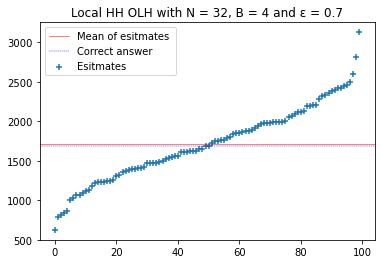

array([ 624.26830665,  782.62194889,  816.69267734,  840.41706712,
        857.6609649 , 1008.84143781, 1022.0853356 , 1064.43167427,
       1068.43167427, 1097.12435161, 1115.7463005 , 1131.19508006,
       1179.06092674, 1224.30482452, 1225.40726541, 1227.75360408,
       1234.50970629, 1237.13165518, 1243.06092674, 1254.92677341,
       1305.5487223 , 1318.51700987, 1354.79262009, 1365.55602588,
       1382.93407699, 1391.48529743, 1398.38285654, 1405.8316361 ,
       1413.8316361 , 1419.62675433, 1466.79992366, 1468.59504189,
       1475.76821123, 1477.14626233, 1488.87065211, 1501.69748278,
       1518.66577034, 1538.1145499 , 1552.73649879, 1555.492601  ,
       1556.46088857, 1609.98039657, 1611.7755148 , 1616.32673524,
       1621.42917613, 1623.7755148 , 1626.94868414, 1645.29502281,
       1649.01941259, 1686.26331037, 1687.9169717 , 1720.60964904,
       1744.33403882, 1747.23159793, 1762.95598771, 1763.78281838,
       1785.85354682, 1802.54622417, 1841.99500372, 1845.44378

In [16]:
class HH_OLH_degree:
    def __init__(self, epsilon, degree, dates, counts):
        """Setup of the datastructere
        Parameters:
        T (int): The lenght of the stream
        epsilon (float): The height of the full binary tree. 
        dates (Array): The dates of the stream
        counts (Array): The count for each of the dates
        Returns:
        A epsilon differintial datastructe
        """
        self.epsilon = epsilon
        self.all_dates = dates
        self.all_counts = counts
        #Check if we are we have missing dates.
        if len(dates) < (dates[-1]-dates[0]).days:
            #print('here')
            self.all_dates = self.__add_missing_dates(dates)
            self.all_counts = self.__add_missing_counts(counts,dates)
            
        #Make dict for date indexing
        values = np.arange(0,len(self.all_dates))
        zip_iterator = zip(self.all_dates, values)
        self.idx_dict =  dict(zip_iterator)
        
        self.degree = degree
        self.h = int(np.ceil(np.log(len(self.all_dates)) / np.log(degree)))
        self.level_prob = np.full(self.h+1,1/(self.h+1))
    
        self.tree_levels = self.__process(self.all_dates, self.all_counts)
        
    def __add_missing_dates(self, old_dates):
        """Add missing dates in a list
        Parameters:
        old_dates (list of datetime.date): List of dates that is not countious
        Returns:
        List of countious starting with the first value of 
        """
        start_date = dates[0]
        end_date = dates[-1]
        all_dates = pd.date_range(start = start_date, end = end_date).to_pydatetime().tolist()
        return [(date.date()) for date in all_dates]
    
    def __add_missing_counts(self, old_counts, old_dates):
        """Adds 0 to the list of counts where there was missing dates
        Parameters:
        old_counts (list of int): List counts for each day with 
        old_dates (list of datetime.date): List of dates that is not countious
        Returns:
        List of countious starting with the first value of 
        """
        zip_iterator = zip(old_dates, old_counts)
        missing_dict =  dict(zip_iterator)
        all_counts = np.zeros(len(self.dates))
        for i, date in enumerate(self.dates):
            val = missing_dict.get(date, 0)
            all_counts[i] = val
            
        return all_counts
    
    def __process(self, dates, counts):
        tree_levels = []
        for i in np.arange(0,self.h+1):
            level = np.zeros(int(self.degree**np.ceil(i)))
            tree_levels.append(level)
        
        for index, (date, day_count) in enumerate(zip(dates, counts)):
            idxs = self.get_index(index,self.h)
            idxs.reverse()
            for person in range(int(day_count)):
                level = np.random.choice(np.arange(0, self.h+1), p = self.level_prob ) 
                tree_level = np.zeros(self.degree**level,dtype=int)
                
                if level != 0:
                    response = self.OLH_func(idxs[level], (self.degree**level))
                else:
                    response = 0
                tree_levels[level][response] = tree_levels[level][response] + 1

        return tree_levels

    def get_index(self, date_idx, n_layers):
        """Calculates the path of index in full binary string

        Parameters:
        date_idx (int): The node in the bouttom layer we want to calculate a path to. 
        The bottom layer has index from 0 to 2**h-1
        n_layers (int): The height of the full binary tree. 

        Returns:
        list: of index in the path from the starting from the bottom and going up

        """
        idx = []
        for i in np.arange(0,n_layers):
            if i == 0:
                idx.append(int(date_idx))
            else:
                idx.append(int(idx[i-1]//self.degree))
        idx.append(0)
        return idx
    
    def get_group(self, idx, level):
        """Calculates the path of index in full binary string

        Parameters:
        date_idx (int): The node in the bouttom layer we want to calculate a path to. 
        The bottom layer has index from 0 to 2**h-1
        n_layers (int): The height of the full binary tree. 0 index

        Returns:
        list: of index in the path from the starting from the bottom and going up

        """
        if level == 0:
            return id
        elif idx == 0:
            return np.arange(0,self.degree)
        else:
            group_index = idx //self.degree
            level_indicis = np.arange(0,self.degree**level)

            split_ratio = (len(level_indicis) // self.degree)
            level_indicis_split = np.array_split(level_indicis, split_ratio)
            
            return level_indicis_split[group_index]
    
    def OLH_func(self, x, g):
        if np.random.uniform(0,1) < np.exp(self.epsilon)/(np.exp(self.epsilon)+g-1):
            return x
        else:
            return np.random.randint(low = 0, high = g)
    
    def OLH_aggre(self, count, N, g):
        p = np.exp(self.epsilon)/(np.exp(self.epsilon)+g-1)
        #print(p - 1/g)
        #print(f'p = {p}')
        return (count - (1-p)*N/g) / (p)
    
    def turns_right(self, path):
        #0 is left 1 is right
        direction_lst = []
        for i in range(len(path)-1):
            current = path[i]
            nxt = path[i+1]
            if nxt == 0:
                #We went left
                direction_lst.append(0)
            elif current == 0 and current < nxt:
                #We went right
                direction_lst.append(1)
            elif self.degree * current < nxt:
                #We went right
                direction_lst.append(1)
            else:
                #print('else')            
                direction_lst.append(0)

        return direction_lst

    def turns_left(self, path):
        #0 is left 1 is right
        direction_lst = []
        for i in range(len(path)-1):
            current = path[i]
            nxt = path[i+1]
            #Checks
            if nxt == 0:
                #We went left
                direction_lst.append(0)
            #Checks
            elif nxt == current*self.degree + self.degree - 1:
                #We went right
                direction_lst.append(1)
            elif current == 0 and current < nxt:
                #We went left
                direction_lst.append(0)
            else:
                direction_lst.append(0)

        return direction_lst
    
    def answer(self, dates):
        """Calculates the path of index in full binary string

        Parameters:
        dates (tuple of string): Two dates in the format string 2000-12-19. 

        Returns:
        float: The private range count
        """
            
        date_obj_0 = datetime.strptime(dates[0],'%Y-%m-%d').date()
        date_obj_1 = datetime.strptime(dates[1],'%Y-%m-%d').date()


        idx_0 = self.idx_dict[date_obj_0]
        idx_1 = self.idx_dict[date_obj_1]
        
        #print(idx_0)
        #print(idx_1)
        idx_left = idx_0-1
        idx_right = idx_1+1
        
        path_to_left = np.flip(np.array(self.get_index(idx_left,self.h)))
        path_to_right = np.flip(np.array(self.get_index(idx_right,self.h)))
        
        left_or_right_list_leftside = self.turns_left(path_to_left)
        left_or_right_list_rightside = self.turns_right(path_to_right)
        #Starting in 0
        
        range_count = 0.0
        
        if idx_0 == 0:
            level_offset = 1
            #print(f'level_offset = {level_offset}')

            for i in range(len(left_or_right_list_rightside)):
                if left_or_right_list_rightside[i] == 1:
                    group = self.get_group(path_to_right[i+level_offset], i+level_offset)
                    idx_sss = np.where(group == path_to_right[i+level_offset])[0][0]

                    count_nodes = self.tree_levels[i+level_offset][group[:idx_sss]]
                    for node in count_nodes:
                        #print(node)
                        range_count = range_count + self.OLH_aggre(node, np.sum(self.tree_levels[i+level_offset]), len(self.tree_levels[i+level_offset]))
    
        elif idx_1 == np.max(np.fromiter(self.idx_dict.values(), dtype = int)):
            #print('MAX')
            
            level_offset = 1
            #print(f'level_offset = {level_offset}')

            for i in range(len(left_or_right_list_leftside)):
                if left_or_right_list_leftside[i] == 0:

                    group = self.get_group(path_to_left[i+level_offset], i+level_offset)
                    idx_sss = np.where(group == path_to_left[i+level_offset])[0][0]

                    count_nodes = self.tree_levels[i+level_offset][group[idx_sss+1:]]
                    for node in count_nodes:
                        #print(node)
                        range_count = range_count + self.OLH_aggre(node, np.sum(self.tree_levels[i+level_offset]), len(self.tree_levels[i+level_offset]))
                    
                    
        else:
            level_offset = 1
            #print(f'level_offset = {level_offset}')
            left_count = []
            left_count_group = []

            for i in range(len(left_or_right_list_rightside)):
                if left_or_right_list_rightside[i] == 1:
                    group = self.get_group(path_to_right[i+level_offset], i+level_offset)
                    idx_sss = np.where(group == path_to_right[i+level_offset])[0][0]

                    left_count_group.append(group[:idx_sss]) 

                    count_nodes = self.tree_levels[i+level_offset][group[:idx_sss]]
                    left_count.append(count_nodes)

                else:
                    left_count_group.append(np.array([]))
                    left_count.append(np.array([]))

            #The search right side
            right_count = []
            right_count_group = []

            for i in range(len(left_or_right_list_leftside)):
                if left_or_right_list_leftside[i] == 0:

                    group = self.get_group(path_to_left[i+level_offset], i+level_offset)
                    idx_sss = np.where(group == path_to_left[i+level_offset])[0][0]

                    right_count_group.append(group[idx_sss+1:]) 

                    count_nodes = self.tree_levels[i+level_offset][group[idx_sss+1:]]
                    right_count.append(count_nodes)

                else:
                    right_count_group.append(np.array([]))
                    right_count.append(np.array([]))

            #print('Counting nodes')
            #print(left_count)
            #print(right_count)
            for i in range(len(left_count_group)):
                #print(f'At level {level_offset + i}')
                """
                print('Left size')
                print(left_count_group[i].size)
                print('right size')
                print(right_count_group[i].size)
                """
                if left_count_group[i].size != 0 and right_count_group[i].size != 0:
                    #print('Both not zero')
                    group_left = self.get_group(left_count_group[i][0], i+ level_offset)
                    group_right = self.get_group(right_count_group[i][0], i+ level_offset)

                    if not (np.array_equal(group_left,group_right)):
                        for node in left_count_group[i]:
                            range_count = range_count + self.OLH_aggre(node, np.sum(self.tree_levels[i+level_offset]), len(self.tree_levels[i+level_offset]))
                            #print(node)
                        for node in right_count_group[i]:
                            range_count = range_count + self.OLH_aggre(node, np.sum(self.tree_levels[i+level_offset]), len(self.tree_levels[i+level_offset]))
                            #print(node)
                    else:
                        #print(left_count_group[i])
                        #print(right_count_group[i])
                        #print(np.intersect1d(left_count_group[i], right_count_group[i]))
                        count_nodes = np.intersect1d(left_count_group[i], right_count_group[i])
                        for node in count_nodes:
                            range_count = range_count + self.OLH_aggre(node, np.sum(self.tree_levels[i+level_offset]), len(self.tree_levels[i+level_offset]))
                            #print(node)

                if left_count_group[i].size != 0 and right_count_group[i].size == 0:
                    #print('Left not zero')
                    for node in left_count_group[i]:
                        range_count = range_count + self.OLH_aggre(node, np.sum(self.tree_levels[i+level_offset]), len(self.tree_levels[i+level_offset]))
                        #print(node)
                if right_count_group[i].size != 0 and left_count_group[i].size == 0:
                    #print('Right not zero')
                    for node in right_count_group[i]:
                        #print(node) 
                        range_count = range_count + self.OLH_aggre(node, np.sum(self.tree_levels[i+level_offset]), len(self.tree_levels[i+level_offset]))

                    #print(OLH_answer(count, epsilon, np.sum(OLH_count), D))
                    #D = len(all_dates) 
        return range_count * (self.h+1)
    
    def real_answer(self, dates):
        if len(dates) < 2:
            date_obj_0 = datetime.strptime(dates[0],'%Y-%m-%d').date()
            return self.all_counts[self.idx_dict[date_obj_0]]
        else:
            date_obj_0 = datetime.strptime(dates[0],'%Y-%m-%d').date()
            date_obj_1 = datetime.strptime(dates[1],'%Y-%m-%d').date()
            #print(self.all_counts[self.idx_dict[date_obj_0]: self.idx_dict[date_obj_1]+1])
            sum_ = np.sum(self.all_counts[self.idx_dict[date_obj_0]: self.idx_dict[date_obj_1]+1])  
            return sum_ 

query_dates = ('2014-1-2','2014-2-2')
epsilon = 0.7
degree = 4
local_HH = HH_OLH_degree(epsilon, degree, all_dates[:64], all_counts[:64])
print(local_HH.answer(query_dates))

for level in local_HH.tree_levels:
    print(level)
    
number_of_queries = 100 
N = 32
plot_estimates_hh_degree(number_of_queries, N, HH_OLH_degree, epsilon, degree, all_dates, all_counts, range_dates, '1234.png')

[1503.31530711 1681.14953525 1800.31347413 1488.         1560.69909652
 1680.72070197 1524.69909652 1601.9315177  1619.68285991 1733.77294765
 1917.44860575 1607.75134221 1791.4270003  1642.6234124  1584.45043873
 1579.57836853 1725.33691255 1586.52612284 1510.44323691 1632.54052647
 1734.81078971 1653.92431588 1755.76574584 1787.43420212 1714.89367564
 1591.0594475  1691.59277216 1839.17834251 1756.03600907 1782.56213192
 1817.52428986 1811.52428986 1479.72253495 1735.26122844 1777.26122844
 1670.3675528  1722.29186868 1641.92431588 1752.56213192 1804.82519334
 1667.68285991 1723.23962299 1750.46484236 1685.23242118 1883.88464084
 1707.24682481 1670.3675528  1790.47924599 1709.07385113 1520.95495613
 1863.69726354 1877.00536883 1534.96215794 1622.97656157 1668.54052647
 1666.10449138 1927.01257065 1614.45043873 1832.47924599 1643.50268442
 1745.59277216 1753.41979849 1572.33874554 1542.60900877 1822.64501785
 1769.77294765 1923.17834251 1629.58557035 1543.82702632 1484.95495613
 1684.

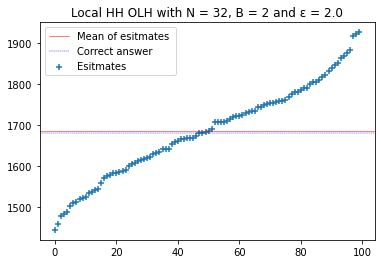

[1480.59761486 1230.07742093 1602.13768875 1554.35082777 1764.41878205
 1245.26843214 1450.72789436 1027.69946425 1399.68522469 1261.72677608
 1650.5743537  1312.42196149  885.85232791  823.63489873 2014.88208184
 1304.76921757 1781.08529786 1755.13293846 1604.35850292 1776.78658378
 1530.45446489 2043.06247797 1928.12141819 1444.83333428 1787.97759876
 1479.21513607 2090.41447681 1017.4908398   824.96341576 2213.76533852
 1699.85748177 1885.72697032 1717.33885492 1450.82385255 1630.41630602
 2043.57275267 1618.92409337 1463.17494621  977.77149183 1630.17336027
 1947.09274105 1846.56418366 1213.25578984 1373.26932978 1801.96133952
 1843.85364042 2143.52081814 2854.09202258 1618.99950593 2066.66803387
 2265.09340297 1500.0706321  2223.63167404 1538.9884458  1625.66218416
 2083.73170553 1717.71501256 1482.3095121  2279.29909125 1580.95909166
 2250.1726531  1333.35716024 1472.76582505 2093.55897701 1209.77057534
 1156.34384848 1666.63463661 1089.27679183 1721.63621124 1320.52491783
 1944.

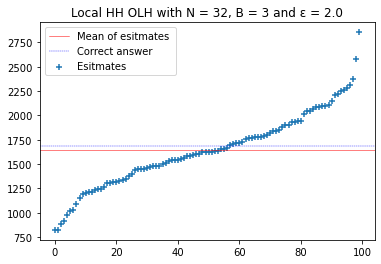

[1363.91576196 2041.26694803 1564.16795561 1577.06285324 1827.70542711
 1848.66038323 1773.07481289 1634.85862832 1894.03574884 1570.97276549
 1540.88267774 1822.57029549 1543.74754613 1874.93064647 1394.36620069
 1881.26096821 1779.75950578 1506.672473   1795.22495913 1685.06883306
 1631.63340896 1799.99973977 1645.54332121 1138.94884618 1582.97276549
 1995.53721127 1487.86168329 1837.49522237 1829.25498838 1762.74449115
 1405.53136156 1771.81956428 1773.01475439 1407.50133231 1713.36912555
 1338.00584971 1644.82859907 1143.60350983 1778.02976902 1624.82859907
 1581.12291173 1584.2280141  1480.04185878 1750.02976902 1861.20090971
 1915.23093896 1945.56126069 1930.75645081 1433.89171254 1889.97569034
 1560.94273624 1704.35411092 1604.3481311  1789.25498838 1228.86473826
 1950.57627532 1744.71446191 1778.02976902 1673.30906705 1542.55235601
 1832.60032474 1680.17393543 1658.67845283 1819.46519312 1493.41722439
 1314.60045485 1776.7745204  1599.45323347 1440.81663942 1713.60935954
 1694.

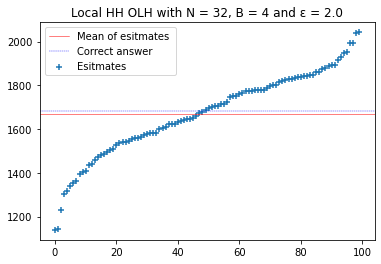

[1713.37536561 1410.31238225 2232.45030861 1523.09912254 1781.91589208
 1870.99694503 1561.84387393  811.89210289 1192.15027636 1526.43847908
 2147.01488451 1752.72070197 2009.0930126  1475.15320121 1450.25830358
 1395.68774786 1786.09606757 1442.67273324  885.62781948 1833.44140393
 1847.89184266 1703.22521936 1827.35131618 1961.0930126  1606.74475139
  874.34254162 1598.5045174  1537.60363994 1319.56165104 2104.50438728
 1480.52258699 1209.40552497 1362.07214827 1821.62157942 2251.97582046
 2136.26415329 1496.34839133 1932.31225214 2071.12902168 1776.06603832
 1574.67871306 1909.44738376 1948.67260312 1724.54052647 1891.95190116
 1692.66064347 1990.04796873 1687.58557035 1095.42957439 1451.68774786
 1485.18323046 1910.1020474  1730.63061422 1486.85290873 1776.96093595
 1563.63366919 1664.         1336.81689965 1815.41137468 1769.13513162
 1845.62157942 1579.75378619 1764.66064347 1344.93701665 1157.10523249
 1673.01501462 2125.16503075 2221.52538173 1455.21325971 1720.
 2082.05394855

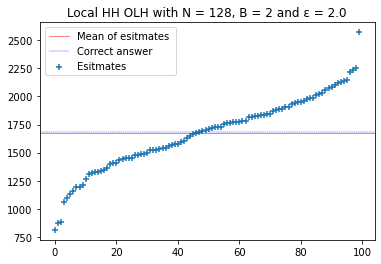

[  838.71944226 -1165.14715729   598.24729437  1375.80246397
 -2283.23506507  2220.28641311  1451.49394192    67.01164472
  -725.97752145  2207.92081965  3671.88525752   275.32159243
  1218.93987927  3094.68140221  2593.69348066  3431.80994678
  3994.98210203   484.85194886  2148.70438616  1692.77069792
  4545.30033966    95.84876377  1490.69565497  1126.99154225
 -1914.93497248   846.11984921   654.03830407  2679.14156782
   776.93457267  2501.31389844   740.61639917  5545.79087774
  2735.8219894   3629.80550765  4824.36765654  3126.50275798
  1733.18216877  2123.56056295  3492.05351861  1292.26613337
  1368.95820534  -347.23506883  3158.48044914  1427.61586927
  1852.34504218  3734.40013353  2664.81228704  1254.9408712
   104.67423243   526.59229505  2877.66474884  4056.81835928
  1574.99585693  3812.02731374  3606.54798289  3796.47238175
   180.04302608  1988.96459061  -192.50462113   634.22155339
  -244.0096062   4473.51221897  1328.42237447  5121.72542212
  3100.06293245  4272.473

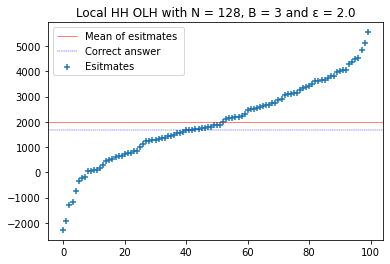

[ 905.6069548  2554.35638554 1383.57413047 2291.22021403 1802.26655803
  994.22404935 1110.78368532  914.60357488  941.59343513 1798.26993795
 2770.2076692  2020.41962913 1970.81605424 1661.71030198 1750.63932373
 1721.65960323 2518.38680479  362.03282433 2248.26077303 1881.19557977
 2244.26415295 1939.15502077 1378.59103005  756.72863181 2395.14923577
 1795.27669778  435.30419252 1636.72720157 1989.79577474 1824.56834547
 2021.76873541 1663.04250868 1693.00870951 3614.56548498 1174.40077987
 1249.67890789 1860.88365258 1799.93097142 1599.40851454  959.91550208
 1866.22937894 2209.95560567 2083.05024335 1510.82521916 2492.74605082
 2201.63353873 2043.75859565 1772.62918398 1585.42879404 2041.40610946
 2035.41962913 1632.73058148 1372.91647691 2152.32499145 2672.93968092
 1855.88365258 1855.22599903 2022.44328854 2356.860968   1115.76678573
 2307.55242072  839.32544686  365.0260645  1361.92999658 1662.03912876
 1097.1327916  1287.65524847 2892.4418583  1606.06954801 1633.05940826
 2151.

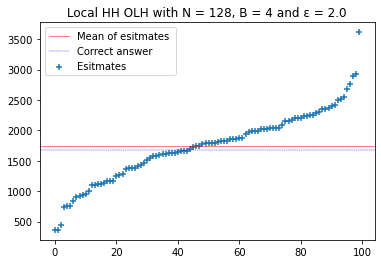

[ 663.56716307 2042.28475774 1582.65831653  698.6651156  1201.81091983
 1059.31433227 2381.6947934   385.23685442 1367.60591491  992.65829071
 1821.61049065 2962.5558657   948.83824521 1803.33258362 2038.74489424
 2458.25288243 1090.73346779  610.02957453 2562.08887849 1297.24828087
 1553.4601365  1377.92482292 1301.22778038 3331.90439988 1676.03645106
 1383.68564191 1133.0728763  1614.81777054 2291.57861534 1133.81319479
 2035.94534923 1410.38495942 1078.49428677 1318.64919085 1077.91569725
 1966.46698721  583.33025702 2702.06382807 2509.43056197 3599.33721099
  967.8792462  2678.76542055 1909.08885268 1622.19818003  970.2391552
 1736.81549557 2559.72896949 1591.95899902 2036.24603172 1773.0934026
 1267.14805337 1704.79499508 3147.53081528 1066.55578825 1686.21640556
 1887.98862518 2029.74489424 2283.15720486 1630.45786153 1259.92937285
 1532.79954501 1394.60591491 1911.74944417  681.26648058  969.63779022
 2326.67656787 1932.24830668 1205.21182981 2157.64239178 1873.69021765
 1724.11

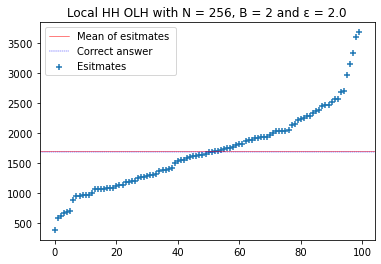

[ 5609.42906779  5283.1316924   6131.57316485 -2417.46197808
  6312.09721857  -214.15630313   227.62366447  3931.84358271
  4265.18415893  7684.5840119   -872.33324995 10589.06634264
 -3123.40929846  -258.14814396  2883.83466817  2339.18763274
   677.3285382     13.53722425 -1569.95731421  -399.79581993
 -2188.01023816  2122.42320737 -2565.75670939  6074.91034728
  1112.03850649 -1790.03105031  2247.20218618  1584.74810621
  -114.51723242  5577.27251826  1606.54889245  -883.81577113
  3465.07606716  7624.2612989  -1171.58134725  -238.53602679
  3081.75657423 -1249.09792089  1170.92216421  5419.51003881
  6182.9693619   5706.78313072  -399.9883228   6404.1745494
  5957.72285495  -964.01292896  6399.5016653   3153.38275979
  8716.49094358  5543.69488665  -171.41031655  1797.02203877
  5686.74309152  1331.21465855  -502.91274387  -823.97047175
   246.39664355 -1252.39152743  7187.82603277   244.98796848
  3076.77163181   543.12287213 -5297.01555589  2487.14529811
  3352.34613386  4084.965

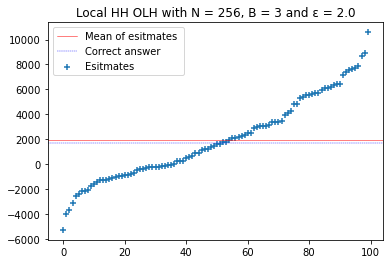

[2188.86915808 1120.35489128 2473.94449109 2608.87689275 2671.81943416
 1825.8005849  2418.68326265 1787.47851796 1901.73636648 1468.0608385
 1698.87832299 2790.71465673 1081.35827119 1121.98212558 1033.3988302
 2957.58621989  220.35632152  764.60500513 2146.55047105 1465.4133247
 2707.47708771 2052.29262253 1726.55963596  768.27279843 2776.75183582
 2174.87253799  270.61754996 1711.55963596 1620.26122844 1518.02703934
 1513.3727657   812.56444613 2377.7136819  1807.80734474 2014.66200831
 1405.11829709 3328.31920646 2198.86915808 2165.54709113 2872.01306426
  795.57458588 3861.92713609 2298.43893379 1779.15645101 1457.74891131
 1562.66441339 1735.1936301  2414.35781579 1174.62963938 2323.42203421
 1748.86142341 1224.94156658  988.76145614 3370.6209939  1622.30178744
  766.28293818 1399.11491718 1358.14533643 -496.10965161 1479.37614561
  982.77497581  685.97101099 1137.31095236 1075.04296408   30.14579184
 3112.83054875 2547.92421158  627.71654239  -45.44426338 2653.84309358
 2784.070

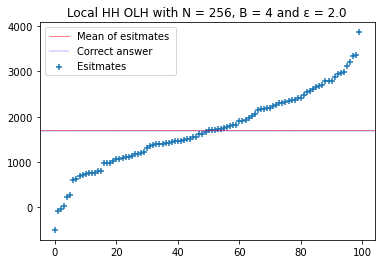

[ 2160.35346103  2027.79044515  -266.47227755   846.6793633
  2314.23178402  -540.26610262  1626.08787784  -294.46551772
   983.25589885  1634.09801759  1075.16126118   553.57699096
  2429.47611288   526.91595748  1003.9135524   1616.77933056
  -629.54085073  1753.99662008  -335.73012607   182.51517762
  3145.59635964  1283.01930467   217.82710481  3551.97010018
  1989.15645101  1240.38869045  3158.26077303  1771.98986025
  2436.81169949  1130.45628878  1393.60935988  1866.57653555
  1027.87637332  2531.41527437  2265.63158906  1404.26701344
  2351.53357147  -331.09275202    29.29450818  1523.50796237
  2393.52343171 -1181.7827745    126.57939604  3468.69873199
   888.65232397  2702.61228439 -1536.85810751  4445.94839043
  1494.85706865  1042.54754654  3986.99473443  -974.59928415
  2376.86239824   432.3123826   2066.44133887  2053.7600259
  1029.2254796   2655.31049695  1309.02268458   738.77062106
   254.45433911  2893.80929441  1742.68131297  -150.55339556
  2861.1617806    576.2076

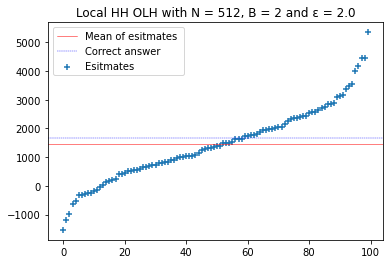

[  7176.29230099  14328.49853516  -2391.07081672    236.56377108
   4256.90902449  -5692.51980573  -1114.09993743  -4566.52793366
  -2500.18082276  -6314.28611206   5021.0201354    1899.60802398
   5510.98972879    519.64392702   1116.51186065  -2633.68492487
   7216.74316821   1787.85838464   7383.5126236    1469.76835619
   5118.39815871   6177.68138736  -7028.01665909   8801.14575137
   -100.44368951  -2905.70181187   4135.12996165   7559.91194979
   3108.27624538   4068.4749152    8164.1157921   -5523.80304212
   6423.66777115  -1405.0580424  -11726.06579662   -105.89339949
   5946.14146789   1445.62802797   2606.94195993   2191.5037457
   -578.25628078   8334.88891325  -6276.60749329   5116.84509511
   4365.84316909   3760.97246839   8828.84172922   6928.29369773
  -3294.34700489  -9712.71097265   3977.11474253   9073.2672978
   5623.36641382   -528.48096123  -1501.18437977  -2692.81335064
   7204.43756221   5061.64657952   3555.0172405    4050.89119984
    997.25160842  -5759.954

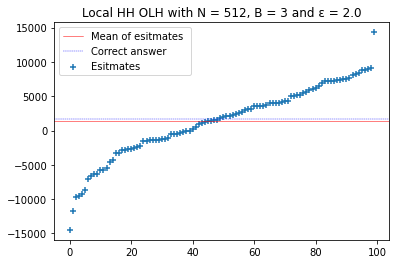

[ 3963.56021993  3558.46408747  3768.76242994  -653.32375638
  -902.91712646  3218.54585554   400.19668525  6216.66298159
   439.69723772  3944.61878347 10794.98784189   353.75469631
 -2285.50276134   -30.10607703 -4253.68839602  3033.4541429
 -3062.66519201  1936.46187809  -440.26077303   975.3546961
  3896.55911498  4580.57237441  1165.09392255  5289.52707031
  1610.16132572 -3995.80110329 -1761.6397781  -3200.37347926
 -1943.49613163  3242.34033068  4194.41767842   468.13922666
  -377.64198852   152.69171296  2838.86187778 -4064.89060603
  4910.784529    2150.67182277  -747.61988894    30.21878482
  2896.62762361  2609.15138062  3343.78342457  7175.68176579
   731.55580116  3634.49502667  1662.86850801    77.13149199
 -5218.70718022   456.81546976  5698.79999834  4014.17900444
 -1855.93591066  4941.99115882   921.29502761  2045.99336976
  1915.43204384  3924.53038569 -2648.53922531  1087.44530379
   784.26298346 -2147.32375586   756.29171275  5167.5248604
  1672.10386713 -1667.81436

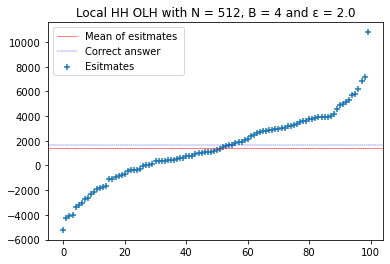

[-1.68900409e+03  3.99202724e+03  4.39429168e+03  5.66704785e+03
 -2.00264506e+03  1.81332994e+03  1.17630528e+02  3.08904023e+03
  3.76735860e+03 -1.36267537e+02 -5.38687838e+02  4.21999886e+03
  1.78378879e+03  2.96496738e+03  4.61946505e+03 -3.88445375e+03
 -1.06502512e+03  5.75617604e+03  1.81960473e+02  2.05393449e+03
  3.48259819e+03  1.34164380e+03  1.45522138e+03  3.07354515e+02
  2.34343781e+03  4.74922635e+02  2.18228265e+03  1.39481787e+03
 -1.23193265e+03  3.09347141e+03  4.89485838e+03  3.79705562e+03
  2.79290418e+02  4.92704192e+03  5.74546099e+02  5.79325835e+03
 -1.03105280e+03  1.76901821e+03 -1.11213510e+03  6.06274346e+03
  8.31513778e+03  3.12153550e+03  1.08234223e+03 -3.33376812e+02
  2.73382187e+02  2.64312466e+03 -3.92581136e+03  4.73445577e+02
  2.28369490e+03  3.51116701e+03  3.98776228e+02  5.75518427e+02
  2.30798842e+03 -2.24891001e+02 -3.63630805e+03  3.47816701e+03
 -2.12737850e+03 -3.64395025e+02  4.21047592e+03  2.91629298e+01
  5.82591984e+02  2.14299

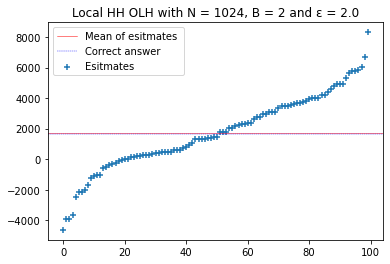

[ 14906.17737165   2949.53647799   -669.63129249   9445.60240957
 -17442.96673412   1620.55070944  -3289.34593572 -10356.60097255
 -35057.35715625   -579.61985275   6629.62158645    873.78992168
  -5679.81484329   8814.20376729   7170.93354085  -2140.31638427
   2869.25237644  -7427.49768575 -11182.04414158   1391.79699785
 -13890.08314831   2596.32251823 -14309.28861268 -11307.69865129
    876.28921105  13840.53814685 -26995.78652566  -3451.27566199
  -3846.38469428  -2591.22363414  13677.97580855  34621.02478165
 -14213.08695599   2332.54039378  -7338.52064212   1656.18355315
  20455.18487034   6979.9410638   26019.06774746   3561.33073823
  -4449.47848326  29245.15337542   3217.98986916  13444.97274889
   7030.42148191  16768.53693941 -10685.91123142   6579.58302214
 -12832.53442949   6289.13704378  24896.0541281   -2377.58937749
 -16164.2965677    6977.65992322   6363.06906819   8597.59371372
   6274.93388168 -10641.39984466   5280.41340221 -13114.46607675
 -12246.72229744  17451.8

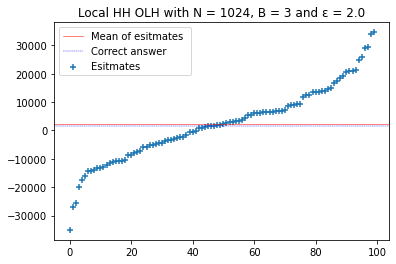

[ 7065.8983407   -451.16022024 -1615.15359001   841.10055279
  6958.19005345  6533.00552321  2673.60662951  1684.99889505
  3417.47403257  3941.13149095  5688.84198759 -2661.05635208
  7211.01878264 -1767.21546841  5036.24088284  3522.6232038
  2551.13370137 -3944.75800909  3712.56795512  -496.92596608
  3779.36353521  1865.50276238 -2958.23867242  1078.63425437
  3135.99778958  3413.56243036    25.79005584  -216.39115955
 -1184.17458463  3004.76022055 -7533.53369847  2696.93038641
   861.18895057 -2551.05414217 -1014.11270623  -226.77347999
 -2170.69392131  3963.77900475  7133.37016389  2099.12486175
  -116.56574522 -2531.17126925  3233.32375638    32.7314923
  3762.7160214   5216.95027504  4240.60773394  5039.27071709
  1598.38011054  7061.72154513  6359.91381056  4644.76242994
 -1565.00552373  1591.43867408  1568.32044204 -2154.51712573
 -3348.30497063   117.79226574  2043.65303857  -409.57126998
 -3006.76905914  4948.41546851   710.2740335  -1428.64972267
   793.92265226  7911.2088

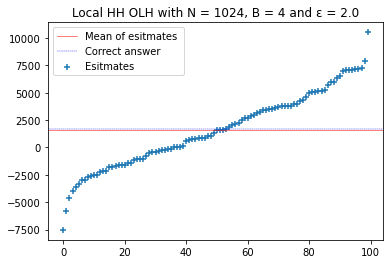

[  671.36353624 -1840.09723637 -2049.45414238  4852.68066187
  -366.92154627 -4016.0220975  -1913.83425292  3962.28066218
  8122.56795356  1209.10939241  5265.59999875 10612.32264884
 -6553.36574304 -2379.4607721   2195.62872909  3270.17900496
  4948.79999886  4376.40662889  2497.86961297 -3231.71270551
  2865.0828725   -637.75027546 -7155.55358814 -1018.58121456
  9683.77458287  2303.07182298 -6091.65082607 -1291.29281666
 -2034.21878326 -3247.21325798  2263.5712705   9830.04198613
  2810.08176755  7437.61325767  2679.0497234  -2725.64419739
  4885.71049612   596.9502766   4986.00662868 -9322.03756528
  6557.86077179  3783.39447441  7616.23425209  -903.04972288
  6884.63204239 -1302.35138021 -3717.69281583 -3004.56132437
  3364.00441929 -1823.9204408    351.06298387 -2637.34806483
  2949.20220949  1854.97458556  8187.27513586 -9095.56242724
  2862.52375649 -4080.7292798   4809.67955692 -1627.50497125
   254.94364688  3111.64640833  1860.0928176  -7150.96574283
 -3659.45635177  7579.96

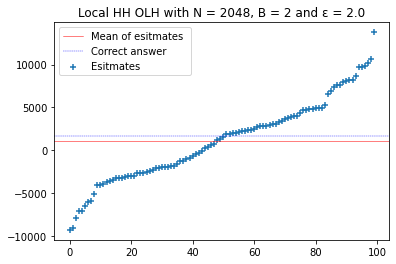

[-1.80771396e+04 -3.64036096e+04  6.08112156e+02  2.75442672e+04
  2.65683397e+04 -2.10499237e+03  3.96193792e+04  9.60229735e+02
  1.23601892e+04  1.23720966e+04 -4.18720883e+03  2.38642965e+04
  4.53588896e+03  5.84537581e+03 -3.40238872e+04 -5.54000580e+03
 -4.46481521e+03  1.45172584e+03  3.34074481e+04 -3.50258307e+03
  6.36559446e+04  8.50936938e+03 -1.08400108e+04  1.92008231e+04
  1.00990270e+04 -2.70416576e+04 -2.72903010e+03  3.06779147e+04
 -1.15533428e+04 -1.65622159e+04 -1.02792194e+04 -3.79596963e+04
 -1.30197466e+04  2.21651226e+04  1.29261046e+03 -9.25950345e+03
  4.08411001e+04  4.81231752e+03 -2.14723737e+04 -2.89695290e+04
  1.41881275e+04 -5.08839732e+04 -3.19685830e+04  2.53804524e+04
 -6.00577225e+03 -1.37275329e+04 -4.32101145e+03  1.41582662e+04
  1.91452945e+04  1.90966517e+04 -3.91871048e+03  2.12191665e+04
 -7.93499126e+03  3.59524217e+04  1.46732630e+04  4.09879260e+04
  4.07837935e+03  1.68504091e+03  3.10345716e+04 -5.66413449e+03
  3.21091289e+04  8.37276

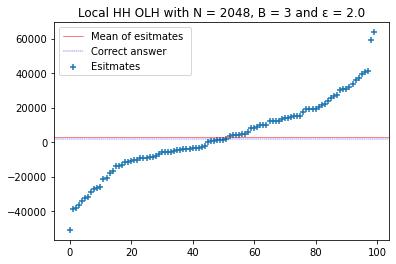

[ 27208.74219416 -13864.68200978   5950.85665078  15680.60931554
  15806.85846727   6193.71201631  16382.85432016  -5223.31446001
   3134.12653802  -1332.02051273   -807.70281386   4596.72332659
   -149.56458854  -5688.38263014 -16859.33942829 -12379.94247179
   2801.55742537   6893.49280254   6420.28188298   6586.85212667
    930.67777702   4117.83387599 -17653.76239844   5394.93198409
   8631.87339342   5709.14403468  22976.73638479  -9343.64249236
  -3999.21597491  -3779.64610823  -6914.37395893  -5109.74383932
  27991.80810223   9844.61481645  -2506.9050622   10869.39334063
   3712.76532885  -5369.06342324  29329.47720804  -8598.43345785
  -9825.7462556   13798.37260512  -3047.68697946  -2253.26400932
  -3072.29394728  -3061.50825993  -7124.47960721   6971.09939335
  10576.57394522  14768.83003734   1586.92315865    165.96893101
   5143.7551496    -565.99019776   8834.40766699  17288.38369261
  -1065.1295541    -978.0587449    -759.81034719  17383.02587652
   9105.08431297   6499.7

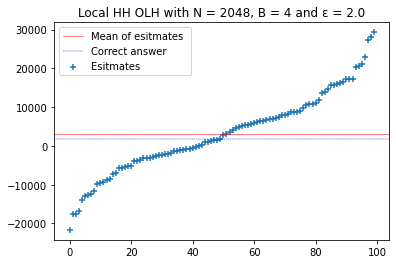

[1457.09686338 1645.52278577 1660.11678899 1527.98717704 1744.73643814
 1655.22647533 1404.49003719 1852.49141954 1982.1951091  1766.06549715
 1470.03846888 1541.30341309 1798.98145673 1626.61964915 1858.49141954
 1738.5683573  1630.8133759  1844.72361518 1529.54843169 1698.09114307
 1577.26494421 1870.73643814 1749.66522068 1759.61392884 1514.8774907
 1589.71651252 1795.40737912 1740.09114307 2053.70507191 1653.04557154
 1874.27204687 1633.9358852  1765.40737912 1573.31623605 1798.32333871
 1624.36180759 1708.15525787 1579.76780436 1878.91734193 1545.32905901
 2057.48569924 1643.26494421 1595.09686338 1555.07121746 1633.03274858
 1816.49141954 1872.95581081 1841.14953757 1772.10396603 1448.05129184
 1778.27204687 1762.52988842 1830.95581081 1736.96863377 1776.33616167
 1542.2450186  1871.60110588 1655.50996281 1834.28486983 1607.30341309
 2023.74354079 1658.14243491 1600.85184478 1501.31623605 1923.96291347
 1798.07832011 1804.94298785 1818.7492611  1884.46577362 1597.9358852
 1370.50

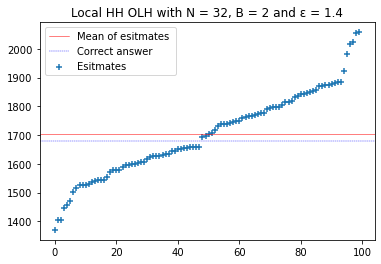

[1377.39138678 1895.77148656 1420.8063838  1821.1368154  2513.87567837
 2801.25701554 1947.92217783 1344.39703028  556.00656565 2345.15289078
  801.53798716 1675.24708003  770.49220873  611.63154595 1903.89288057
 1692.36031225 2070.52219994 1543.14850819  588.27010687 1639.31239781
  588.78590231 1574.7905766  1812.93843435  423.47635801 2493.86850578
 1295.57908777 2756.67430619 2651.03529595 1108.15646885 2742.09350819
  869.54461985 1447.41976188  675.12894886  812.81663808 3405.65962227
 2177.49373427 2625.74153532 1207.24298914 2960.08372676 2691.13906197
 1246.41924552 2085.98603356  468.01061302  887.3508931  1021.51440044
 1752.80262813 1528.65171221  817.35280446 2518.88109721 2459.73895
 1042.49211815 1905.61384738 1269.12319126 2039.44964253 2491.87720745
 1330.89787363 3094.43691348 1633.19138607 1559.27685013  690.03219781
 2123.78497661 1066.6199202  2856.7546431  1801.48971043 2589.19255287
 1800.40265024  764.49121953 1554.23556838  860.23781849 2375.42513366
 1413.993

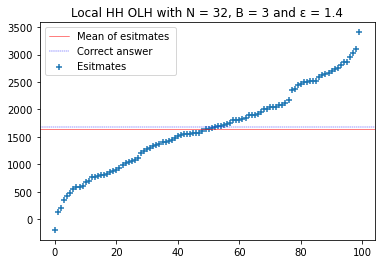

[1479.18741839 1536.17696299 1909.6417514  1404.60623813 1610.45709771
 1299.83133111 1608.26337095 1740.47939088 1461.29473718 1666.80134723
 1400.30519259 1507.83271346 1608.60762048 1493.68219069 1725.98461858
 1326.02505787 1771.57625425 1896.39436526 1393.20832921 1628.95187
 1793.46893547 1650.15605217 1693.98461858 1988.52397721 1350.67035293
 1530.32748576 1632.95187    1113.46478842 1338.62714895 1263.83133111
 1532.77905407 2032.86822673 1844.05011573 1155.01322011 1397.85362428
 1428.00414705 1530.02644021 1600.86546204 1537.68219069 1747.53305027
 1797.46893547 1967.27659106 1745.3825275  1616.26337095 1233.03551327
 1932.1365237  1468.99369164 1545.12330359 1811.96370776 1884.39436526
 2112.65358916 2083.40620301 1676.99507399 2134.54627038 1199.70171916
 1516.17696299 1428.95048765 1491.48846393 1741.68357304 1323.22924003
 1566.41389372 1979.5776366  1665.25291554 1935.79227417 1346.36930739
 1444.04735103 1974.02920491 1421.2515332  1383.61669354 1561.16650758
 1787.920

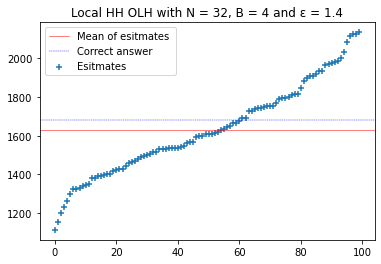

[ 900.46833208 2495.31703035 1344.21325522  982.40421728 1622.02091082
 1505.03136623 2388.133759   1447.05227704 1045.88853417 2110.15328747
 1906.15190512 2176.77767172 1852.56026945 1596.77352467  845.07042316
 1329.9331205  1330.66482353 1342.32057401 1757.63483966 2054.0668795
 1564.73032069 1720.68849905 1912.94772296 1519.22509298 1283.18050665
 1613.46202372 1981.29197248 2223.57348955 1145.1150095  1604.25784156
 1141.37285105 1993.16374288 1802.66758823 1615.31150095 2381.33794116
 1448.34286718 1405.11639185 1701.59163567 1778.58118026 2206.28289942
 2394.28428177 1829.72124763  609.54151994 1515.48293454 1795.26967931
 1980.17419829 1498.19234441 1591.26829697 1517.28920778 1760.77490702
 1458.23554839 1496.98816224 2483.61807589 2165.03551327 2028.17419829
 1988.73308538 2260.00414705 1738.58118026 1630.70940987 1249.24462145
 1836.51706546 1827.3128833  1232.64253037 1916.04458633 1074.27598768
 1588.77352467 1158.01814612 1373.71848293 1635.65575047  915.866241
 1286.879

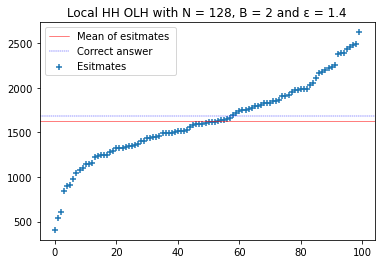

[ 5.06972242e+03  7.91756637e+02  3.58308979e+03 -3.66342274e+02
 -1.25814732e+03  1.53986402e+03  5.05682778e+03  1.02784412e+03
 -5.23450249e+02  2.63618538e+03  2.26196962e+03 -4.58699698e+02
  7.09066715e+03  9.03262138e+02 -3.93943903e+03  3.18279733e+03
 -4.84842168e+03  1.23354440e+03  4.01343416e+03  1.81892233e+03
 -2.74306291e+03  6.91903484e+03  1.78725958e+01 -1.80603308e+03
 -1.21258578e+03  4.58398331e+03  3.64761760e+02  2.81000151e+03
  1.53915498e+03 -1.65432273e+03  3.62549567e+03 -8.76463933e+02
  1.71826646e+03 -4.48886064e+03  2.37922442e+03  2.04598931e+03
  4.16594591e+02 -3.85746345e+03  4.04322127e+03  2.28525324e+03
  9.23040899e+02  1.28246212e+03  4.53196332e+02  7.09376301e+03
  2.68386353e+03  2.79046502e+03  4.42201326e-01  3.98014702e+03
  1.57077734e+03  3.29854715e+03  3.93294718e+03  4.45639180e+03
 -4.51713121e+02  3.71617533e+03  2.26907549e+03  3.54634613e+03
  9.32571584e+02  9.00010712e+02 -1.14556175e+02 -1.41058330e+03
 -3.04074712e+03  3.92713

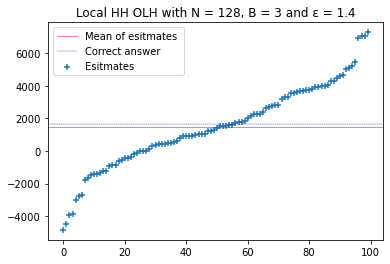

[ 1.69076458e+03  3.10415413e+03  1.58138471e+03  1.30164875e+03
  8.20000000e+02  1.37976216e+03  1.64192556e+03  1.64551398e+03
  1.29936643e+03  1.78116031e+03  5.62546358e+02  1.38461704e+03
  1.37204448e+03  2.70547367e+03  1.97821822e+03  7.23482935e+02
  1.57953776e+03  1.14114754e+03  2.12172736e+03 -1.42281646e+02
  2.23295418e+03  2.34276942e+03  9.02968288e+02  2.64177977e+03
  1.45957740e+03  1.86112067e+03  1.62493349e+03  1.59667495e+03
  2.76108572e+02  1.50370667e+03  2.22067186e+03  1.96336334e+03
  1.30679387e+03  1.22154327e+03  2.17726821e+03  1.72974872e+03
  9.12387799e+02  1.51584386e+03  3.06016998e+03  1.79786214e+03
  9.53944504e+02  2.33305966e+03  1.65435300e+03  1.80757189e+03
  1.28679387e+03  2.42287490e+03  1.63493349e+03  3.06788767e+03
  5.42836603e+02  1.05633230e+03  1.26052741e+03  1.07546157e+03
  7.30329884e+02  1.88112067e+03 -1.15155536e+03  1.77887799e+03
  1.39874631e+03  5.52836603e+02  5.30844531e+02  3.40772911e+03
  9.00685972e+02  2.32048

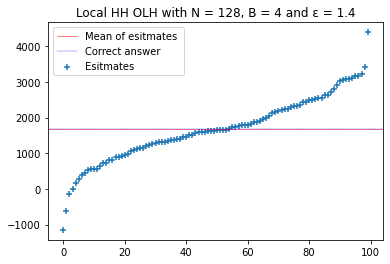

[ 960.79571472 1314.59834118 2330.15520109  746.34428053 2113.55374962
 1398.69858309  896.29519634 1564.64984449 3716.86518856 1982.95298933
  742.04424597 1889.30245367 1636.55063934  414.84168863 2754.10853601
 2364.70584043 1842.40200441 4757.97268781 1646.3505011  2661.25786211
 1610.75043198  172.04009892  898.99550736  889.8451445  1273.74801287
 2968.95990108  489.69236252 1411.34911875  546.54303642 3364.41271761
  866.59488531 1236.64742537 1524.34980993 1063.0463195  1108.74697611
 1535.09989632 1244.04770184 -369.06359886 1284.49809927 1548.
 1576.7500864  1876.40234999 2190.95437168 2675.35775844 1697.95091581
  119.23989157  400.34186142 1629.70065662  658.59350296  567.09298458
 1513.99965441 1011.04597391 1898.70238455 1989.00311029  411.4918787
 1136.94676876 2557.25717094 1394.94884228 1582.2499136  1422.89906691
 3147.81126615 1631.30038015  547.34289818 2889.95955549  630.24334744
 1548.         2317.80539116 2614.9077066  1264.34808199 2051.35361139
 2042.35361139 

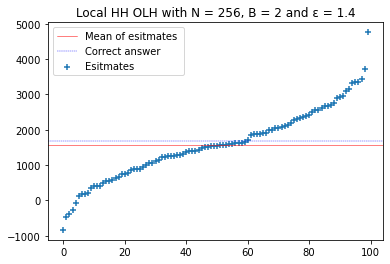

[ 12309.35684603   9810.52460096   1940.8446877   -2785.22737583
 -10167.35843658   1354.74008866  -3032.18963836  12426.68775831
  10209.01225795   4036.70224555  -5591.83984563  -6122.72566772
  -6241.15071163  -1819.11285328   -752.74525675  10539.49787478
   3464.5391072    7462.82205361   1186.86343867  11403.62968242
   3432.88179772   5863.42842811   8154.76597369  13660.02046144
  -5386.9615115    5946.65610641  10019.65523796  12563.23820552
  -3208.60215918   1834.86763468   -325.81735029  -4238.61800877
   2148.1253591    -921.73783199  -2922.35426884  11630.41631391
   1489.44947165  -1554.47359342   2263.43770412   1061.39200283
  10601.710601      221.82410478  -3825.89562442  11943.12491267
   7696.79052849    204.78204664  -4717.07269685   -666.8047419
   -752.99756618   1401.27539593  -5514.80994144  10244.65101329
  11794.41079394   -354.51367941    519.0091089   12204.13049583
  -5248.44024986   3925.42532469   8397.78108083  -2496.68115985
   7809.76227564  11016.70

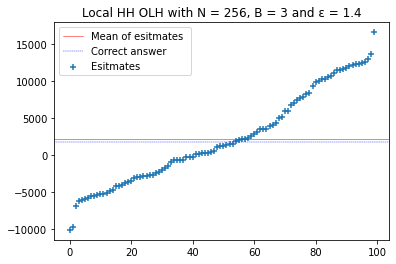

[ 1434.06342363  2602.82249529  3628.79804081  1470.03963977
  2624.95968961  3099.18100169  1898.13961343  2568.40298438
  1966.39814616  2289.24751505  -212.65049943  2512.86213506
  1994.80180117  2043.93106753  3636.37060195  4596.66017588
  1715.50120956  1090.19819883   371.24092833  1381.78110704
   176.90069696  1448.04756772  6032.04179551  -150.40782261
  1000.09271633   499.16957675  1316.38537999  2038.93106753
  1046.64942156   127.62630832  1165.59392589  2814.73528781
  -358.5870758   2291.52983164  1340.8048909   2447.75665256
  1665.10548251  2549.85420711  2683.65358916  4730.6046802
   470.04031039  2056.35850639   412.50738902  3852.99314992
   760.50188018  1835.46156979  1985.81765707  1761.62254797
  1557.57256114  2624.81456734  3280.94867193  1714.92072047
   390.3701947   1431.63598476  1494.60427295   971.39881678
  3481.15963694  1997.80972912  3607.82182467  1861.43778593
   981.54393905 -2033.70465387  2116.89935572   981.25369451
  1956.25302389  3838.138

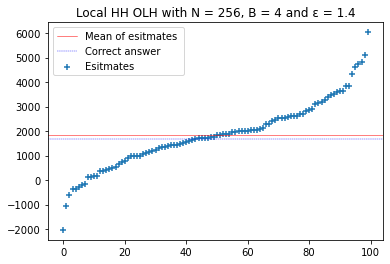

[ 3693.00658671  5506.77842456  -387.49194036  2649.31335779
  3165.38161963  1120.42260064  1198.10064428 -3750.15453535
  1054.88175132  -596.83217174  4267.04313675 -1608.67845089
   606.78177766 -1511.00040725  2822.2420062  -1957.93940274
  -715.19618698  4131.39680492  3592.61085966  2007.59876411
  6211.60642869  2705.72494074  1041.58357882  2797.96761757
  1726.01585591  3568.62671557  3499.3919667   2567.65117005
  1852.82316591  1421.13477521  1202.66527747  1288.20612679
  3520.65842738  -409.04864559  3374.43160647  2588.91763074
 -3269.23139577   364.32813582  4373.26995767    24.19645034
  3479.68221124  -713.05899266   264.8031424   2342.87557186
  2237.22924003  8950.41723568  4541.34372836  2602.90177483
 -1854.14002068  3170.81698645  1543.08720749   890.10615313
  -443.90352332  2002.74388638   869.81590858  3267.62429646
   420.15922969  4451.81873494   826.70249812  1628.62805681
  2036.43778593 -1535.85528498  1861.37194319  2080.13168548
  2314.32679458   509.97

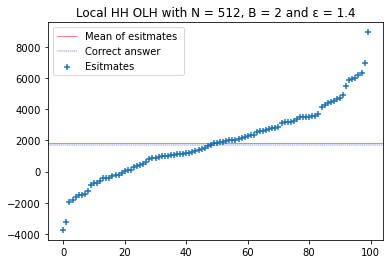

[  2932.81958246  13148.20697979  15733.45787514    422.2565037
  10387.22112451 -17764.04430872  15967.13501439   4677.77064518
  -6353.23765643   7117.68760288  -2221.60716152   6687.52312331
   -249.17480263   6625.24615652  -2756.63430451  -6524.70286025
  -6899.74064779  -7745.44317372   6957.02485216   -385.19905804
  19060.14731374   -349.59950365  10555.32719599   6409.51827844
   1034.55638882   5353.57668479  -3674.37815684    243.69167452
  12160.38814635  12303.22424105  21636.25383657 -11820.40974486
  -6898.94008636 -10062.39144901  -2285.06082744 -12613.85052925
  22706.41305379    589.54574668  13165.69380248   -204.07539137
   5285.20411633  13730.11171862   7933.46369238  -9474.12335975
  15017.50447702  10470.66213196   2460.70171546  15952.6955557
   7043.8488454   31347.35643626  -2261.19855285   1621.93170293
   2550.04911548  -5586.08288213    482.40405007   1680.36793528
  -4803.3831609   -7840.17568498  -4625.54044534  -6885.89144674
   6313.3449607   -5432.387

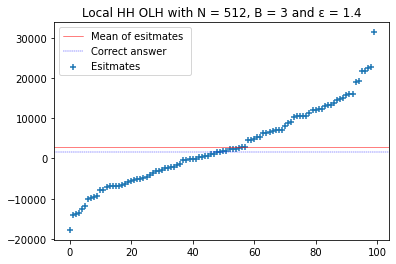

[-1.24690387e+03 -2.89208625e+03 -5.24531224e+02  1.80051003e+02
  8.52419165e+02  8.04087915e+03 -4.34546477e+03  4.17231820e+01
  3.33482597e+03  4.64987667e+03 -3.27548440e+03  2.02008965e+03
 -2.76827669e+02  5.66501545e+02  6.26568780e+03 -1.23657035e+02
  4.73261917e+03 -1.93085287e+03  5.46972984e+03 -2.64733030e+03
  4.03382736e+03  4.81504730e+03  5.18075982e+03  2.57423926e+03
  3.21723617e+03 -3.59677327e+03 -5.95264267e+03  5.86470882e+03
  1.39522929e+04  5.89144684e+03  7.87571870e+02 -2.76722877e+02
  1.80775734e+03  3.53547265e+03  5.95324174e+03 -1.02278115e+03
 -8.93086557e+02 -8.07238936e+03 -7.51529214e+03 -6.09402289e+03
  2.94868980e+03  5.42256817e+03  4.36395905e+03  4.42301593e+03
  2.63340093e+03 -3.08673293e+03  8.16943122e+02  4.13226119e+02
  1.25360773e+03 -1.39133648e+03 -1.39428409e+03  7.74864716e+03
  4.88305179e+03  2.56844884e+03 -1.34712242e+03  8.70398534e+03
  3.29945472e+03  1.98461360e+03  5.07454128e+03  2.89268532e+03
  4.03677497e+03 -2.31130

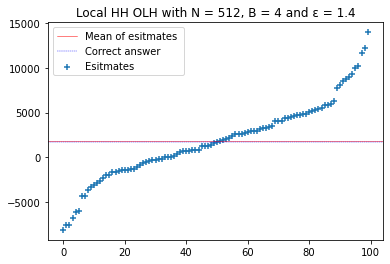

[ 2.48912804e+03  7.22882744e+02 -2.80785447e+03 -2.41538277e+03
 -2.43937064e+03 -1.35404314e+03  1.68932075e+03  1.68148113e+03
  2.56717790e+03  3.36160243e+03 -4.04413345e+03 -4.69322375e+03
  5.25258897e+03  5.59439355e+03  1.22330877e+04 -5.36969680e+03
  1.44709703e+03  4.66247441e+03 -2.68229787e+03  7.24268736e+03
 -4.55865502e+03  5.48381269e+03 -4.07888682e+03  1.85618598e+03
  3.34346632e+03  5.31156471e+03 -9.56742593e+03  2.16078033e+03
  3.02248922e+03  2.79079650e+03  1.22002687e+02  1.69739488e+03
  3.59622103e+03  5.49457819e+03 -2.88099059e+03  7.68407281e+03
  5.98376005e+02 -6.57859303e+03  3.84359300e+03  5.44636794e+03
  3.91087737e+03  2.79372238e+03  7.94876553e+03  8.51834227e+02
  2.25743531e+03  6.41620083e+03 -5.73075483e+02 -7.66854460e+02
  9.76591244e+03 -1.73060110e+03 -5.24004181e+03  1.35804717e+03
 -8.73087741e+03  9.41334236e+03  9.19118594e+02  8.54063346e+03
 -2.03504895e+00  7.69799868e+03  8.84522780e+03  9.44809573e+03
  6.37805258e+03 -3.43541

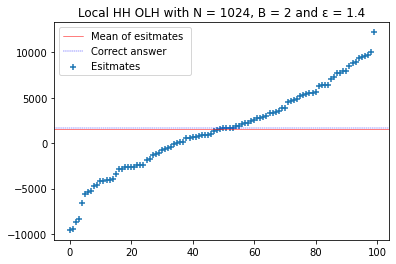

[ 59696.48014421  -1529.49461294  13019.90461435  46932.33378823
  14826.67094454 -11290.59233809  36097.68826309 -12570.33980046
  42912.4250181    3569.34131068 -10809.87827441 -64586.55948419
  -5257.54799065  -4913.03563165  23462.86651077   8470.42258039
  28172.75165625 -31688.55883349   6136.16320718   1021.77319579
  10591.95593397  29888.91843903  -7254.9951751   29781.33746844
  22432.85453339  -2906.52648798  32587.1523273   25187.20122482
  25669.03588245  -5661.04847769  12489.40680363 -22802.65454241
 -15876.63481794 -21326.5375211    4063.11811123  -8241.03514217
  -3058.59960111 -10737.39743285 -44218.15059717   7226.63605501
  29567.37454164 -17162.62083396  15063.31743346  15382.31665937
  -4559.22477756  -8829.60560358 -38781.56320391 -46995.65247213
  43492.84428602 -20989.04669212 -26742.96597902 -32553.79788481
  -8730.53153064 -24461.10338018 -26055.1387794    3486.58295402
 -12987.59749864 -44743.3092454   -1108.53536777  13223.41552657
 -33620.93609264   9998.8

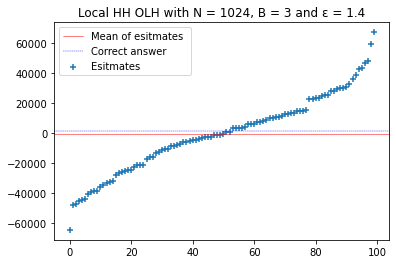

[  6975.88842025   6914.61747721   -784.09243241   4661.3902696
  -8514.80682438   2352.99691027   7495.1907398   11402.02397913
   5419.44854025   1571.77697027   2695.02380442   2577.0148397
  -2146.30480032   8031.86431136  -5519.20248977   1748.63323034
  -2116.61917431   5410.71051857  -1468.1462207   -2732.66848025
   6908.30310322  -2181.36167835   3266.85904533  -3764.85395402
    200.72178935  10918.19770293   5478.40062694   4151.55951104
   7118.0021763    -208.99521316 -11418.82584196   9470.40001798
   1574.93415726    899.30401665  11911.95952902   -374.3754299
  -4616.71160672  -3938.86740109   5068.5788331    6925.98872923
  -7004.89986574   4635.07141325   2046.44605947   6124.34514154
   9998.23077654   2683.44296974  12339.36215754  -6097.14252201
   9712.41794741     41.44636395  -5244.97049532  15842.05922904
  11634.6751389    4534.9576572   -4602.18316771   5440.08177059
    182.93137201   6542.90495706  -6267.99878209   6728.60403014
  10599.64685213   1916.9610

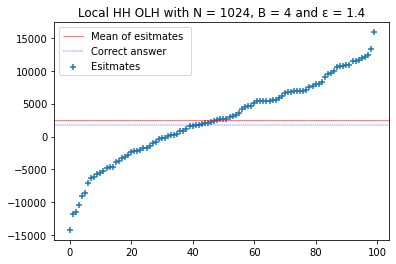

[-11715.36772805   -299.1000045   -3725.05457196   2534.59567438
    163.8834587   11654.05087328   1956.44605947   5167.22551051
   4424.21963553  -5517.82675539  10878.41176795  15124.0099231
   3601.62844351   2283.63014061   -567.33199895   4005.65982001
  -9674.99678051   2985.57913757  16833.83001984  -4574.38378566
  -1725.95008511   1970.97449848 -11662.31085002  -5296.54684764
  -3017.62953166   3996.60742435 -18178.19309081 -10474.21672051
   -302.04760883 -11868.64315345  -1985.54884922   9725.47930779
  10173.72474932 -15365.34022495   8940.99738946  10332.89538339
  20714.13482016   -585.01762495   2923.46986388   2139.19752822
   1419.98207057   1272.60185384  -1357.70912595  -3374.28965614
  -5146.21902657  -3232.80464808   1148.59288912   2755.45641681
  -6535.16941616   6482.06662641   3336.55363605   4562.96662191
  14973.47251938   8802.6695684    -691.131381     2109.72148487
    558.86243954  -3315.33756945  -7817.79646704  -5644.36415912
   2371.84868799 -14861.09

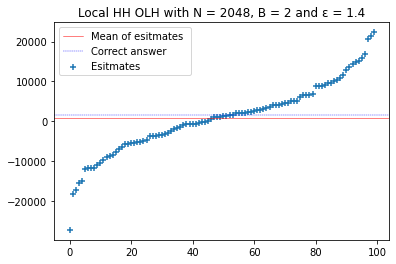

[ 38436.88329472 -15020.00378819 -22829.22952632  13655.93656255
 -40770.45933096 -31451.67996005 -12916.92856213  -9394.17901477
 -11518.58979515  -9087.9464023   12150.15443699  -4124.58714108
 -25989.73623916  41726.25386345  -3537.68781982  45962.11191586
 -16328.7450291   43536.79996819 -20394.44328434  30732.9315441
  42906.3815621    5891.46906897 -39527.86079912   1054.64683552
  71448.51940311  19723.04228766  24979.14891638  22583.21807723
  -8475.70999935  32398.55290226   1315.68215726 -14158.38470028
  -1459.15341885   2635.23898486 -23871.25506064 -43538.79435713
  41408.94672616  18165.16432095  -6745.85054998  -2094.03865769
  75283.15593734  -6887.34095504 -40352.80152352 -10164.4752646
  -6445.53245848  27086.51282528  21543.56547866   4345.12877803
  41233.24771186  23370.93364732  12389.73633587 -34073.08854766
 -29501.94582325 -42799.03283345  54872.83902398  29140.26214454
  -7561.09442505  14541.14231346 -26099.30652526   1851.32919977
  67717.42131889   1212.937

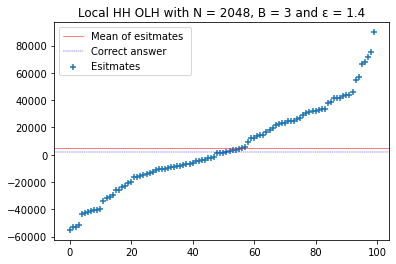

[ 18171.86910816   5313.33490985 -23128.73855177   5413.35550537
  -7497.01551161   5047.66095593 -19931.22239758  13594.75853305
 -15912.94959084  -6845.05511983  11677.02026006  -1929.94391159
 -13384.7407866   12735.85897812  -8724.85454624   7655.29846727
   -667.61501644  47024.26988211   2233.18630934  -6034.54339753
  20324.1384327    3785.33206078   8993.50505557  -5530.9914339
  10304.32381124  -2837.12927125   7310.39986204 -26250.2749849
 -35321.51641408   3581.8418837   18433.99204813 -10532.32729344
  18340.86942472  -6175.95182568  -8135.07793129  15371.19040578
  28578.07219537  16002.25282546  15233.12893579 -11753.26835596
 -15012.76423119  10542.20182096  12742.85897812 -20421.08044491
 -17278.85009546 -12249.92234749  13080.85961125  11235.44801747
 -23487.33107331   1998.65525779  17826.97050292  27577.7642123
  -1409.24904559  14101.75948274  11966.73508846   9328.15873054
    988.00031656  29936.97269998  11318.32571062 -31282.54969102
  21303.75249945   3257.6371

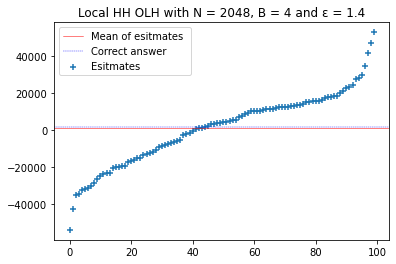

[1681.00842047 1764.81005489 1599.30584465 1908.46310141 1765.78529024
 1731.5208028  1786.29767257 1452.76027721 1481.42149581 1690.47944559
 1728.23155071 1832.19861397 1426.80980651 1341.45443255 1586.34720187
 1456.26448744 1880.57875257 1961.50445862 1925.88459723 1785.71916838
 1586.52897489 1398.36354604 1721.45468094 1443.65279813 1893.93412653
 1786.11589955 1872.06637025 1761.91753396 1541.81822698 1387.14041581
 1760.16542885 1724.94229861 1782.03318512 1773.73576094 1666.08271442
 1835.4712735  1849.8018828  1832.57875257 1551.48761768 1667.43808838
 1635.32243722 1765.78529024 1481.60326884 1541.6198614  1516.26448744
 1711.38855908 1269.23947441 1638.41332373 1701.5208028  1579.9504707
 1876.90936188 1802.18202141 1950.84324002 1650.21495814 1708.09930698
 1587.88434884 1392.56191162 1887.53739536 1613.81822698 1636.66121861
 1639.5703321  1794.62828187 1694.74393303 1606.66121861 1874.77711815
 1854.06637025 1659.30584465 1868.38038699 1544.52897489 1548.97523535
 1514.3

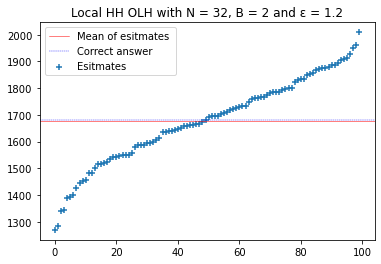

[1477.86456321 1226.69812261 2502.28099286  916.2235286  2328.61747937
 1599.42059762 1046.05179643 1486.32379619  849.25167445 2815.34121887
 2570.47468936 2708.74383201 1742.83585556 1129.79122423 1289.2623057
 1806.43595865 1214.34871039 1907.8657813  2272.45427041 2160.29387131
 1444.48232176 2184.1186266  2969.81862273 2040.23879685 1895.49014316
 2136.34707224 1597.30632798 2507.13487757 2691.26296285 1071.39170185
 2500.04313406 2285.64951229 2851.56676102 2171.36697577 2241.11455226
 1676.00070354 2413.61855659 1783.85449462  902.12906886 2917.1229827
 1377.12920974 2108.82269621 1657.16545788 1980.1392792  1235.95551041
 1849.14887962 1923.51257565 1538.20816844 3042.40008676 2288.59757584
  942.64965145 1667.72060235 2045.69812347 2517.12284182 2371.55350717
 2526.44148559 1250.37783982 -647.2336453  2326.26961254 2359.09408693
 1922.24830365 1215.54123605 1765.12246642 2579.24343385 2761.43947205
 1214.35657817 3118.4569875  1726.66323344  483.37638721 1163.59869858
 2526.94

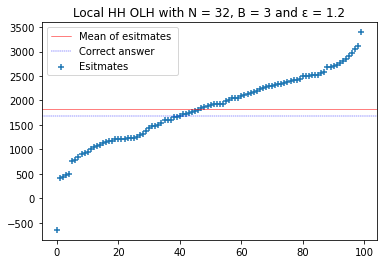

[1940.76176752 2073.33498924 2318.56942957 1609.49967293 1692.75045743
 1966.45881249 1650.16089154 1303.08610082 1738.63480627 1350.71149307
 2081.70959699 2500.69639082 1868.10054892 2120.25516444 1881.13637527
 1876.28785279 1717.92958922 1297.90696903 1595.42802021 1967.49463885
 1625.83028223 1189.62035817 2115.59394583 1921.79759388 1966.64611636
 1326.05027446 1800.66246054 1516.50784502 1378.00627601 1663.00941402
 1733.59897991 2117.85290242 2202.65742646 1085.85166049 1500.36453959
 1495.14140935 1998.08420474 1387.74731942 1406.14958144 1628.607152
 1287.64801244 1475.84662641 1789.6982869  1789.36767759 1693.59897991
 1855.06472256 1629.31236905 2376.97169159 1123.21809615 1878.69011481
 1528.32054114 1664.9377613  1822.0288962  1557.3563675  1533.02575819
 1131.21809615 1818.92141713 1302.56818764 1900.80576597 1525.73097525
 1652.607152   1784.66246054 1550.20488998 2044.34316133 1908.76176752
 2238.28281871 1520.17723571 1329.86297058 1963.8692466  1682.30419697
 1476.55

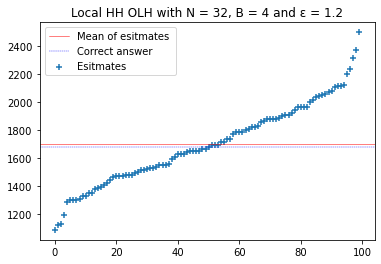

[2957.89690087 1322.62225424 1546.9088651  2496.98175975 3026.7014249
 1659.10747907 2239.46070856 2950.93272722 1710.77686977 1726.21495814
 1876.05530854 1244.12068524  860.38467591 1003.92207127 1428.69390696
 1975.07479072  787.91076118 1564.04399845 2455.09741091 1693.36643566
 1663.81269613 1738.54556745 3499.94717532 1317.81773021 1539.57008371
 1410.62225424  816.24137048 2180.16592562  834.3130232  2269.67566671
 1529.12382325  796.28536893 1099.17285577 1977.52105118 1485.16782169
 1300.21999223 2284.2652326  1830.68887288 2331.70332098 2091.87931476
 2329.44436439 1607.71338914 1268.78190385 2057.14644344 2314.8547985
 2126.98679383 1440.83721239 2027.40540003 1879.16278761 2261.67566671
 1765.84035039 1516.41860619 1694.77686977 2169.05844655 2975.59394583
  349.39788208 2400.40853803 2376.88245276 1511.42677828 2525.12506518
 1444.50660308  759.76745575 1635.00817209 1580.04399845 3160.72907917
 1915.11878917 1871.16278761 3121.10368692 1704.66121861 1924.3419194
 2476.276

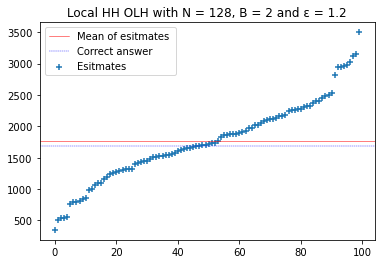

[-6072.43046675 -1067.69448998  1760.27831305  -394.31075865
  4034.34895659  -695.21922147   -68.45938382 -4971.66373494
  2980.00103255  3890.52571851  3644.20362765  1609.84568054
  1881.35538912  4489.6278969    999.16126087 -3393.64089802
 -1427.05737148  1358.32091091  1065.22390314  6132.63573822
   644.67883637  -453.53232009 -3964.56311104 -1076.10947613
 -1753.53344541  3051.68868299 -3041.60893967 -3979.28229806
  2532.93414688 -1447.7260738   5224.13931991  2041.64261813
  4725.40046301  5634.51442444  3008.75435056 -2409.26069744
 -1038.82002723   431.17776371  2744.3019736  -3039.2706078
  2674.8562563   2596.35011661  1331.64863059  3438.64916679
  2582.1655242  -2772.40596092  2424.65840093  6464.95535648
  5440.2617573   3198.0390415   1176.86112523  1216.27894942
  1377.29400137  -486.70444587  5187.778771    1044.21124923
   135.95509688   235.16326445  7126.09709831  1625.94812987
 -2766.19371901  6018.10127453  5269.20375118  1629.00583602
 -2650.20477118  2483.547

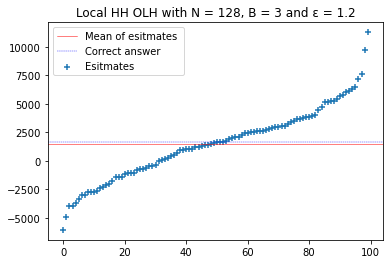

[-390.37364312 2114.49565621 2730.61223882  807.21071686 2294.59920448
 2722.82295568 2399.47538123 1401.46777737 2750.43664144   33.02570546
 2993.73244175  892.26249099  824.07023895 3970.81028456 1474.8356268
  606.52860231 -133.00760386 1225.78566282  770.70238953 2035.5492405
  228.70782001 2531.96524374 2462.66763327 2317.21289024 1957.35698846
 1334.38088376 2501.38667746 2300.35336814  830.         3570.20021912
 3372.30738771 2249.95039924 1826.55105066 2839.38305714  685.65061539
 3337.83417986  300.970311    378.05720461 2668.34974782 1593.60644512
 2648.70094259 1816.90224543 3479.21868394 1656.79869716 -303.11115213
  879.47320785 2515.85988531 2580.33309317  215.91853687 2753.40152196
 4407.92867733 1989.04091318 4137.9489523  4792.7845791   853.89464157
 2824.73425191 5755.61658558 2731.54199987 1298.80231748 1378.85409161
 2373.72121757  554.09051393 4527.45365931 3031.17053012  786.63215058
 2254.0206382  1431.11658261 1196.13685759 3131.22230426 2072.05756783
  642.28

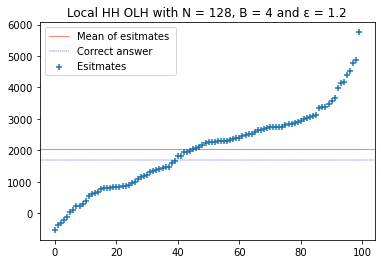

[ 2.83096044e+03  1.86085578e+03  2.63025974e+03 -4.14339517e+02
  1.95202744e+03  1.59488641e+03  5.48244408e+02 -9.07245072e+02
  1.93400256e+03  3.50506255e+03  1.62790300e+03 -5.01738369e+02
  4.18706766e+03 -4.67217628e+02  2.48656733e+03  3.32799618e+03
 -1.21735916e+01  9.24532223e+02  4.74338037e+03  2.33165604e+03
  1.04081748e+03  1.05356541e+03  1.11809444e+03  1.07722463e+03
  7.86856408e+02  2.00227952e+03  7.95091889e+02  1.74905807e+03
  2.34626548e+03  3.20834526e+03  1.67853733e+03  1.82972559e+03
 -1.41032229e+03  2.83807404e+03  8.60003186e+02  6.98310778e+02
  1.84810785e+03  2.96975815e+03  1.41407211e+03  1.33355445e+02
  1.18073707e+03  2.58225144e+03  3.77959149e+02  1.34918570e+03
  1.84996937e+03  6.24042112e+02  1.77258445e+02  1.85035163e+03
  2.41530696e+03  3.71777155e+03  2.84745630e+03  1.50672304e+03
 -1.03120730e+01 -1.44520041e+03  2.20336248e+03  1.51834907e+03
 -2.06882591e+02  2.42581111e+03  1.29852648e+03  2.02440970e+03
  9.12141667e+02 -2.32403

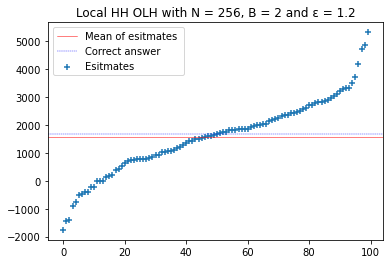

[   514.40697474  -2959.19302268  18758.50465227   5619.03059904
   8477.24403254    825.60596459   3523.20925917  -1801.59927298
  -2494.25804667  -2011.11480218  10176.37143049   5423.55334516
  -8849.9541472  -10602.75733257  12152.47985031  -2535.27210868
  13375.23529996    600.19476008   1900.05321903   -173.72806289
   1050.55704434 -13940.40268497   7505.17012363   -305.8577081
  18979.13489653   3334.67260377   2945.1890075   -3883.83707893
   6259.12260249  -9624.09777711  -7133.5307825     932.2418004
 -11237.92854836  -6447.95771627  -8853.02925611    553.69255111
    -76.36699673  -2888.96275987   5996.63379558  15021.29425685
    -60.82944228   5814.55035348  -2950.10541078  11532.16415005
   -804.94340462  18106.41661498  -5764.55897479   5075.84944466
   4546.62040635   3384.14318981   5336.16543492   1766.18301697
  10443.04119456  -4150.70717916     37.94821176   7746.44441056
  15188.11628044  -3218.10132733   4159.80812864   6927.90771067
    534.30424451  19173.152

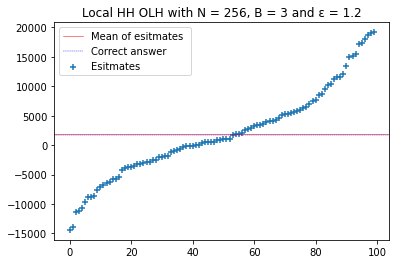

[ 5442.20601282 -1273.21687378  3926.27407839  4217.00796708
  2207.62490994   341.66147635  -303.34974782  2939.37183296
  2191.11658261  1991.18863172  2447.02606868  2167.22194104
  4302.05974121  1405.47501801  1508.66727005   274.39898536
  1841.48805235 -2438.187548    1109.91672671   582.57096242
  1396.75597382 -1603.07277555  6479.33562976  3041.28312919
  2773.33852365  2486.49927653   978.53222263  4535.17994414
  1471.80774796  6008.84938757  2748.33852365  2744.61947946
  1862.94460555  1329.49348283  -576.87291965  1239.61730608
  1250.19587236    72.0329461   4060.79906038  3814.53837955
   975.74293949  1180.14409823  2545.796887   -1230.60318802
  1690.63034042  3029.24800971  2663.63794428   454.32693625
  4514.02281158  2470.74511287   -65.6325138   2538.93736491
  4500.30376739 -1716.84359387  3561.41817662  4741.96741712
  1326.70419969  1396.75597382  3381.49022573  1496.80774796
  2865.24981987   925.1643732   1373.03692964  2635.67306375
  1267.23099184  4777.72

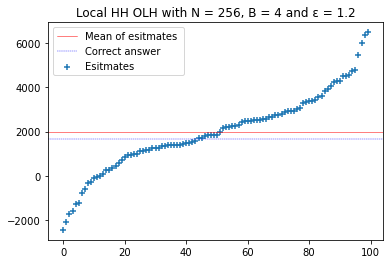

[ 5710.57386224  3196.45872657  1486.87979707 -1415.28349241
  1118.88341739 -2428.86966255  3061.53077569  5696.50362329
  -797.48298509  2732.48081171 -3482.10463793   611.88884787
  1383.10897875   120.47284463  3564.80630102  -336.82114552
 -2378.46669365  3478.47357107  -730.79906038 -1578.00072644
  1552.10716859   917.27154179 -2543.7458393   3229.4236071
  5522.68103083  2207.34576429  1582.10716859 -1024.67342697
  -134.85807515  3179.77480186  2477.85228145  -449.13541065
 -1250.35554152  2961.12780679  5264.38523052  1821.15713256
  5369.26140727  3752.34793766 -1566.84359387  1792.61368576
   419.92577751  3691.94496876 -1745.84178371  3050.42541726
  2278.85409161  1798.54344681 -2765.00652014  4351.95619294
  1466.12563341  1612.51013749  5066.84359387  1533.56372178
  2583.48262187   441.7852996   1295.26792147  5083.52751859
   746.41382986  1232.65423571  5127.24656277  -595.51991473
  4174.8175252   3088.96886406   684.15133887  5878.81788842
  5375.19116832  -676.677

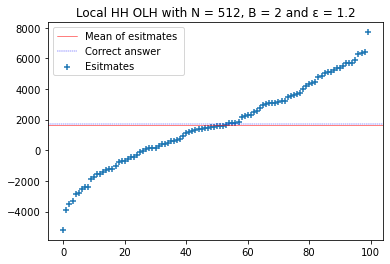

[-2.09068995e+03  1.10676729e+03  1.43686082e+04  8.28491025e+03
  1.36270249e+03  1.60890717e+04 -9.73831897e+03 -4.97179916e+01
  7.19429662e+03 -1.30369974e+04  5.32418671e+03  7.92802563e+03
  4.37216836e+03  1.05069871e+04  1.61015052e+04 -8.16407885e+02
  3.88806334e+04 -2.33856763e+03 -2.47960066e+02 -2.67646293e+04
  3.71807791e+03 -1.45859425e+04  1.25788032e+04  3.25200559e+04
  9.13418808e+03  1.95193680e+03 -2.53006160e+03 -4.94781644e+03
  3.72744785e+03 -8.12068483e+03  9.29914877e+02  9.82664662e+03
 -2.39546981e+04  9.12266329e+03 -6.47763419e+03  5.37540831e+03
  8.18701658e+03 -9.10274492e+03 -4.44483644e+03  4.23250661e+03
  8.78444500e+03  4.79455645e+03 -5.90834655e+03 -3.36001591e+03
  6.41666503e+03 -8.84241948e+03 -1.10784584e+04 -1.52758376e+04
  8.47894773e+03 -8.74453099e+03  8.23077756e+03 -2.47633008e+03
 -8.70075477e+03  1.10950589e+01 -1.40337185e+04  1.17247423e+04
  9.82072204e+03 -8.68102675e+03  4.01217596e+04 -1.03269706e+04
 -8.35563326e+03 -4.20558

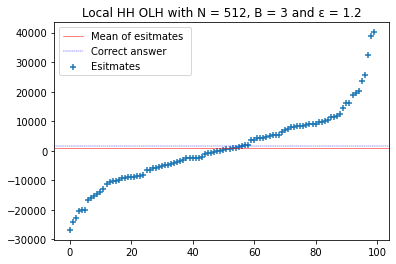

[  -325.27040534  -1791.75501898   3864.1738927   -1232.52278521
   6153.90664492   3567.7560793    2824.91303025   6773.14311998
    431.97455229   4661.02012271   9569.30534914   1762.85153162
   3034.92575411   -169.26086244   4123.38916132   8550.44639527
  -2437.39234229  -3965.08162134  -4333.5026157   -2269.38279939
   9348.49304941  13315.92356327   6500.7263669    4344.20146105
   -625.28737048   8665.65318133  -1141.31705947    475.17709706
    598.78473137   6648.33612186  -3266.64048087  -4008.28416611
  -1909.36159297   5486.66804923   7663.59486366  -1095.71472677
   4976.63836023   6092.70303983   5695.48034896  -6743.24279018
    946.80381716  12736.28942092   6691.53760631  11515.81859146
   1856.45704529  -9969.03067912   8735.25763468   1610.44326111
  -7954.11340758 -11746.33395441   6955.55351113     49.15164935
   4567.41460903  -4481.11131034    430.77412816   1048.81017908
   5009.04026881   5804.68607469  12726.68920885   4915.43475514
   5622.27568354  15438.8

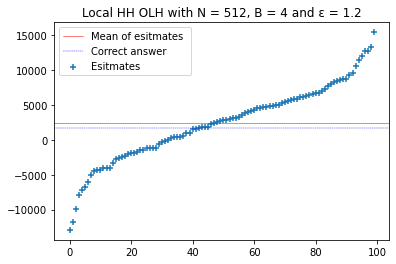

[ 4551.13228391  1301.80619087  8574.98423786  8465.36666426
 12482.89906423  1168.16708291 -7806.92444326  6647.38858203
  4364.76966124  3352.16843011  1196.61411236 13924.99212412
  4266.15208763 -1214.20765413  3225.10382706 -2108.46779693
 15133.81773528 -7497.92271263 -2771.48202535  5870.45876038
  4519.27052655  1093.57104366  2783.47375566  4763.66545074
 -3623.00788626 -6311.09710147 -6972.97308726 -3588.99711909
  2042.57623553  9726.78831467 -3115.63276579  6249.63103517
 -8234.26726221   120.54431744   248.74716312  6410.70640539
 -2429.60777019  7506.62719049 12887.23111601 -1578.08190929
  2350.56719898  8926.72025038  5287.47683348  6177.31148119
  3438.77523654 14827.97578165 -7675.43434512  5191.00826969
   873.32512928  7994.27879624 -4600.46010758  5126.40146326
  -930.49317596  -294.78773434 -5953.92482669  4371.34416614
  1481.59430863  1355.54047276 12806.06057184  1983.53316683
  1800.45779662 -4767.09921553  2558.80234619  1958.11843892
  7608.40454108 -5182.43

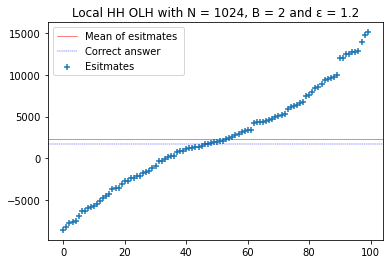

[-6.31533342e+03 -3.03081401e+04  2.45681866e+03 -6.42204800e+04
 -1.36272053e+03 -1.55683589e+03 -4.02161919e+04 -2.99968787e+04
 -3.55948672e+03  8.52781740e+04 -1.91184872e+04  1.38922169e+04
  3.34306091e+04 -7.09014031e+04  1.28203771e+04  7.51947497e+03
  3.54429063e+04 -2.89958731e+03  1.68935033e+04  3.59264781e+03
 -6.05468400e+03  5.21581368e+04  5.55965175e+03  1.67344082e+04
  3.40110989e+04  7.00236743e+04  2.33978217e+04 -6.70585205e+03
  2.27482479e+04 -9.33182369e+02  4.70681092e+04 -3.27831094e+04
  1.13906671e+04 -7.82116995e+03 -3.69045881e+04  1.91325004e+04
 -1.47529246e+04  2.39126692e+04  5.46822690e+03 -1.33342904e+04
  5.08923267e+04 -2.03544575e+04  5.72537518e+03 -1.85277208e+03
  1.32745758e+03 -6.05756878e+02 -8.82003272e+03  1.03778969e+04
  4.69309708e+01 -6.62969597e+04  1.63738890e+04  3.67884658e+04
 -1.28100355e+04  1.50044558e+04  2.51668998e+04 -2.70384566e+04
 -4.63625444e+04 -9.06063109e+04  5.98472756e+03  3.93126313e+04
  5.82604030e+04  1.55085

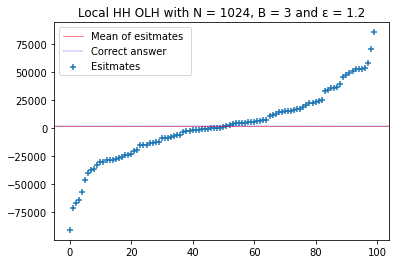

[-1.42473297e+04  5.11099680e+03 -7.87735837e+03 -3.83792467e+03
  1.67696743e+04 -4.20754609e+03 -3.25319180e+02 -1.59709425e+02
  1.56824114e+04  8.74000738e+03 -1.04755100e+04  4.62256838e+03
  2.35113478e+02 -9.56105719e+03  1.36998971e+04 -6.67368923e+03
 -8.59350990e+02  1.22406107e+04  4.65377092e+03  1.13801601e+04
 -8.91902008e+03  9.03642519e+03  6.16225766e+03 -5.56962455e+03
  6.28226508e+03  7.44633294e+03 -7.59654182e+03 -6.11925657e+03
  5.83103815e+03  3.73331600e+03  5.48181758e+03  1.79133403e+04
  6.36867017e+03  1.84320679e+03  8.45679105e+03  1.18757900e+04
  3.78372003e+03  1.12721548e+04  1.14293637e+04  8.35147408e+02
  2.13947432e+04  8.16757472e+03 -5.46881968e+03 -1.34657898e+03
  2.17775661e+04  4.53136371e+03  1.01104867e+04  3.70720052e+02
 -3.21718968e+02  1.73229066e+04  3.56410709e+03  4.60576668e+03
  1.48918558e+03  1.01944920e+04 -2.39784091e+03 -6.08536569e+02
 -7.23742295e+02  9.18523431e+03  1.96474421e+04 -1.68739976e+03
 -2.77226296e+03  1.30218

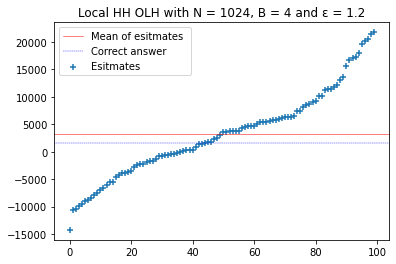

[  1958.4178134   -1110.16010852  12022.20353489   3009.67973616
 -17743.12712156 -12956.04868118  19885.06032132 -19416.02424699
  -8712.60226251    307.12196035 -16279.04229585  -3829.5174602
  10646.92464699  -3446.69561758  -6791.29050464  -2631.84832725
 -12354.81326645 -19581.63400195   8591.20355829  23052.04545342
    800.35101316 -28153.73256503    -98.50051846    964.7614043
   7707.95435938  21130.73369555  -5891.23748857  18566.18546263
   2485.24813859   1791.60869463  -9658.25655096 -14357.73053799
 -12783.2385021   -5545.61713041  -5602.02115963 -14120.11654174
   6080.65850634  -9444.64467536  -3631.50579667  17955.34877551
  22932.03909149  12063.00735205  -3200.68183341    497.93319976
   1812.01060321   3656.51642328  14722.36046245  16841.68388385
 -11789.57997236   8267.18447251    280.72111209 -17422.70824784
  -6168.45381752   3439.30433562  -6983.30110785  10038.48880813
  10344.50683359  11038.14627754   3417.70306323 -13529.68176321
  -2721.85362886 -16849.075

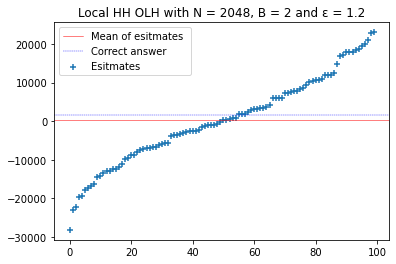

[ 3.26466244e+04  3.07784759e+03 -6.79408757e+04  1.04332269e+03
 -1.26788331e+03 -4.07817145e+03  2.26804708e+04  6.12597365e+04
 -2.16537932e+04 -4.51866094e+04 -2.93624971e+03 -5.86325751e+03
 -3.30002334e+04 -2.10089797e+04 -1.03656713e+04 -3.64472255e+03
  1.21674990e+04  3.62422640e+04  2.17426656e+04 -3.97316994e+04
  5.87750670e+04  5.53136053e+04 -3.05520574e+04 -4.99771583e+04
 -1.90014930e+04  7.45544984e+03  4.45035247e+04 -5.60210249e+03
  1.38041067e+04  9.88353469e+03 -9.21203530e+04  5.64804924e+04
  3.41783753e+04  2.00668742e+04  4.80846896e+04 -7.95494305e+04
 -5.53228592e+02 -4.48611770e+04  6.60958192e+04  3.54735421e+04
  2.64638864e+04  2.48081339e+04  3.34078043e+04 -2.49327294e+04
 -1.38438789e+04 -1.33469477e+04 -2.35528531e+03 -1.29838979e+04
  2.76585144e+04  1.29416505e+04 -4.11909222e+04  6.60538991e+03
  4.35040016e+04  2.80530404e+04 -4.77531621e+04 -4.17493644e+04
  5.41631564e+04  2.81160877e+03 -3.74715103e+04  9.91292207e+04
 -4.03822962e+04  2.92589

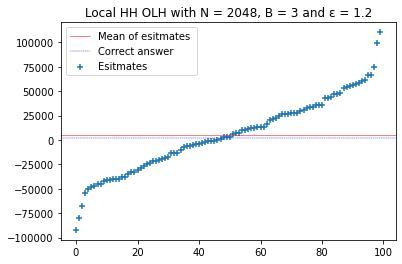

[ 29147.06502017 -25840.87499362  11899.4400243   11579.28234244
   5437.37297733  12194.3220997   -8972.38409469 -32517.78469552
  19855.55525151   5892.33389366    639.28335584   5833.35747858
 -17414.37364792 -21674.6755337     153.40902981   5466.86118487
 -33541.44675727  34690.78503232  -7571.01313815  13764.19709933
 -25176.70922558 -18815.74460446  22642.87196243   6720.79110371
 -15507.49056213  43090.64857478  37376.99931739  41253.95450514
   5391.03436548  46234.61117511  -2265.98618525  15659.86758404
   9343.81637262  26470.70113941  -7554.16273384 -20360.34399762
 -22039.74662525  -3870.98719564 -24285.06299938  41906.9076721
   7261.42924374  22714.48618074  21914.09197608  29530.41171819
 -10910.18059018  21644.48550714 -25267.96124712 -59003.5808482
 -16441.2627991   15755.33220667  42433.48280674  12223.81030724
  28460.41104459  31449.93260722  15070.10343324 -26453.12735196
 -53197.25436712    679.98416445   2730.09568687 -40517.45113565
  -2705.52189942  35988.266

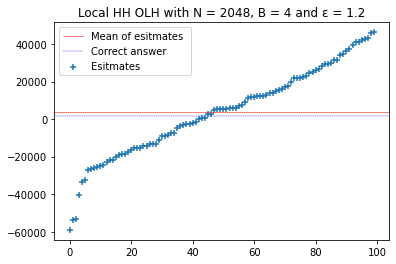

[1784.92391859 1629.31918204 2013.76404794 1815.74751379 1827.95754613
 1715.80650181 1790.50385391 1450.95810538 1596.01653415 1674.84012935
 1752.84012935 1814.30208864 1687.67199163 1455.3026479  1513.65545749
 1719.94927906 1823.41123835 1689.32744912 1904.71388625 1381.84895568
 1441.85722275 1698.01653415 1560.         1566.42006468 1983.36051741
 1985.41950542 1705.88202397 1441.85722275 1596.00826707 1532.6973521
 1651.25192696 1704.84839642 1742.08378923 1666.36107666 1629.52921438
 1836.03306829 1506.         1855.68852578 1612.77287426 1897.89855811
 1826.92391859 1642.97463953 1543.03362754 1788.02480122 1626.84012935
 1560.21003234 2010.86493057 1622.48731976 1703.60473654 1769.19293894
 1696.36107666 1834.99117367 1810.16757847 1533.73097965 1146.79879399
 1415.78996766 1441.03362754 1680.21829941 1666.35280959 1799.20120601
 1437.72271257 1557.31918204 1552.76460719 1501.24365988 1436.47905269
 1766.90738444 1559.5882024  1455.92447784 1699.88202397 1682.08378923
 1333.0

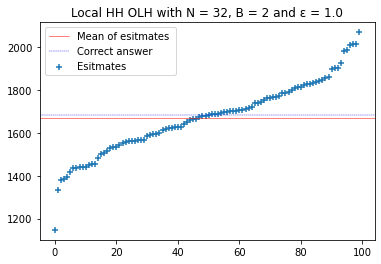

[1317.44317833 1350.15589217 1510.96979032 1788.60547268  -31.28286252
 2302.13767491 1090.36531625 1844.53870242 1897.05742833  396.64634954
 3418.90543259 1556.96511001 1538.34840554 -127.13782421 1353.06670028
 3238.67760456 2369.46676657 2165.48959416 1452.83189613 1487.24171965
 2811.04988759  783.48144208 2474.37232041  378.15768401 2361.55571114
 1838.84487782 2078.73064184 2648.57608427 1801.00001869 1217.00904333
 2725.59957448 1088.82934365 2971.44295906  493.53769446 1073.69719836
 1202.58714806 3511.82494804  478.93848401 3133.14852877 3209.09021854
  380.15579415 1028.97356068 2924.65066127 1163.04542656 2361.93161524
 1738.82795777  955.8518446   811.75558791  934.91886217 2156.82722517
 1352.93044864 1911.17396947 1990.38980507 1481.00724214 2230.88627735
  589.72724939  683.46016836 2273.18612989 2094.27129475 1841.3099738
 2805.31499944 4251.4563654  1984.74985771 2909.69583117 1138.89578727
 1918.48589377 1916.83469593 2159.15606951 2535.07821677  996.7440108
 2322.13

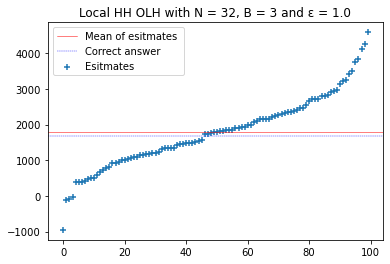

[1308.49171264 2296.77503013  549.21334728 1186.95974257 1786.07879653
 1928.3108744  1994.93821572 1711.86049712 1609.91948514 1655.30592227
 1261.58708389 1221.03250904 1168.20064676 1369.19182043 1119.22325154
 1752.28331749 2049.56555704 1958.10635344 1895.6107666  1626.8831019
 1421.33735337 1270.41894617 1477.0738444  1275.65985036 1734.89688036
 1549.90570668 1632.95586837 1769.24693425 1800.28331749 1856.29709594
 1945.27449116  990.10032338 2669.79376071 1370.02368271 1783.87427558
 1972.17911991 1891.20172469 1979.62454506 1807.18794624 1729.93326359
 1697.37868874 1318.28719168 1860.8516708  1071.63229345 1057.83681441
 1740.13778455 2258.14768881 1855.05619175 1241.58708389 1675.5832097
 1403.54187433 1742.48783844 2136.06114388 1393.06006595 1394.57825757
 1603.16038933 1598.8831019  2091.91561094 1911.20172469 1327.8053833
 1516.38751506 1303.8053833  1795.59698815 1541.21937734 1499.55565279
 1998.25188638 1051.20947309 1874.09257499 1233.73261683 2386.02971278
 1768.283

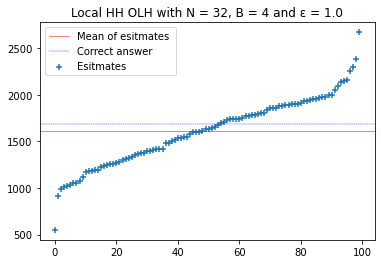

[  66.24757465 1036.04908376 1605.22712574 2921.56555704  376.63896391
 1448.51323949 2293.60086235  969.83078435 1181.17201192 1282.70398199
 2242.28719168 2753.53800013 1838.36383235  124.74316149 1368.79052691
 1148.34014964 1918.37761081 2921.28826962 2014.11410183 1776.29106588
 1780.1593114  2692.56060491 1325.74036522  412.50720943  960.72163464
 2563.16038933 1294.01765265 1202.69020353 1213.44929934 1326.29494008
 2073.44155095 1664.         2187.10527551 1493.76792213 2373.0738444
 1386.99504787 1636.13175449 3903.22153321 2334.16921565 1856.02755691
 2375.83294021 1635.85446706 1059.4945089  1790.36383235 1438.86329338
 1246.83573648 1590.89085029 2655.87427558 2681.24693425 1613.22712574
 1122.67642508 1420.381485   1930.80043117 1167.93110773 1533.76792213
 1588.13175449 2780.29709594 2629.10140131 1595.85446706 1043.77179633
 2835.75629955 1429.75414368 1913.69128147 1926.65489823 3351.41614991
 2150.97352102 1246.55844905 1907.34122757 1920.58213176 2978.39741932
 2213.0

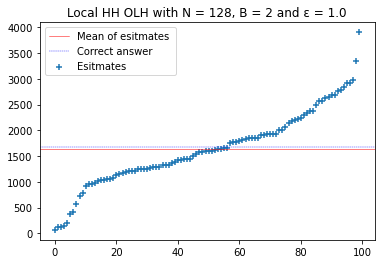

[ 3.22261821e+03  2.81336938e+03  2.00407771e+03  4.61032352e+03
 -4.86613754e+02 -1.06212930e+03 -2.77520509e+03 -7.02166820e+03
  4.76306268e+03  4.25548636e+03 -3.36337957e+03  7.20755730e+03
  8.44876740e+02  4.68842973e+03  1.17731104e+03  6.16694145e+03
 -1.54905605e+03  6.49378249e+02  4.36866422e+03  1.37849084e+03
  1.19023755e+03  1.76849233e+02  2.61020910e+03 -3.80597140e+03
  6.12402170e+03  6.49411199e+02  1.87220892e+03  2.86957126e+03
  6.61248925e+03  9.46246046e+03 -1.89466812e+03  2.07771149e+03
  1.39844823e+03  3.57605159e+03  7.89499072e+03 -3.94421463e+03
 -1.66092465e+03  3.19390005e+02  5.69994686e+03  2.10077328e+03
 -3.08511554e+03  3.73636266e+03  1.67374246e+03 -3.99206467e+03
 -9.09984721e+02 -2.42365643e+03 -1.16258726e+03  2.79082119e+03
 -1.71745287e+02 -8.42473485e+02  3.52274163e+03  2.04836336e+03
  1.61040438e+03  1.31738943e+03  2.67248518e+03  3.16112822e+03
  3.57881141e+03  7.76079532e+03 -7.02996892e+03 -1.04914336e+03
  2.46055706e+03  4.03257

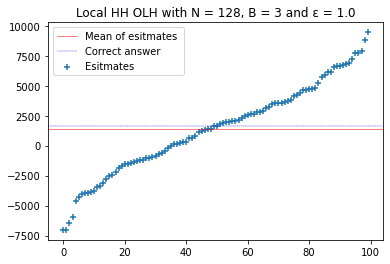

[ 3549.5881658   3708.92594876  3919.99161121  1635.4757823
  2603.3959138    734.46716877 -1292.93541946   127.29967543
  3726.68332226  1647.71840879  3010.87643144  2276.61378164
  1613.2331558   2663.23035954    67.97997669  1470.62325234
   363.19978362  3843.42928598  3529.75372006  1287.31496339
  3694.44069576  3411.97826234   242.31775965  1382.33304761
  3773.7603945   1092.62798769   998.47384321  3557.3455393
   614.96383156  5185.37417613   982.60990346  3110.54532292
   126.95048268  3084.68138317  2520.96964882   564.26544607
  3399.73563584 -1264.82885321  3219.18472039  -357.95629994
   902.07707224  3908.61292446  1687.03810753  4016.90312919
  4029.14575568  -601.09903463  1496.83638483  3062.43875668
  5859.61874172  2145.21701066  1587.02002331  2218.15802265
  1151.08374667  1250.58708389  1196.26738516  2006.22842045
  1230.23789115  2918.10097372  4762.02971874  3306.09623837
  5290.39226036   489.94574733  4554.7509238     35.38815745
  1201.26738516  3507.5110

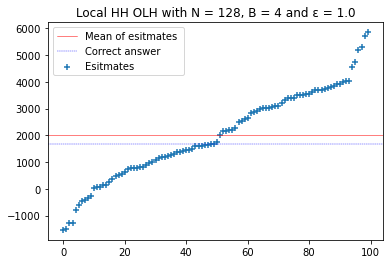

[ 2021.55345635  2553.36762341  3175.7084214   3137.93709722
  2233.24508228  2756.77731169  1736.09050623  4614.27307473
   585.57390526  1757.2022394   2164.54824687  -835.51737899
  1596.11173317   361.05248382 -1717.03918944  3227.74566579
  1151.52103243   714.58992272   660.06329179  1786.69162593
  2862.71884037  1549.96275561  1019.39328181  2647.10170321
  2101.11733166  2464.89946382  3284.13933661  -548.18738897
   721.00482047  1567.24469327    17.85545391  1621.8670399
  2137.64396258  2928.73485782  1611.52663092  2584.81976556
  -401.07565581  -732.8790149   1744.27672817  -191.4425012
  2441.82497504   983.39328181  1872.14376807  1716.12775062
  2772.81455608   -87.36801242  2027.87263839  1625.07448878
  2444.93670821  1902.15978553  2360.29834412   540.04727434
  1544.17020449  1408.83500499  2999.29873313  3575.49055356
  -470.39483785  2360.29834412  2858.17098251  3762.86299745
  2792.05924934   152.56830677  3613.9799401   1827.14376807
  3549.83096254  1678.2607

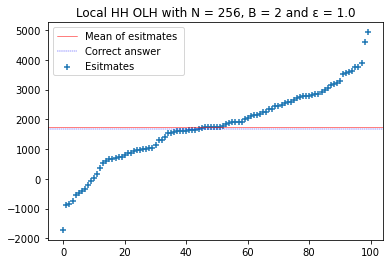

[ 10182.73257306  -2924.13811836  -9802.38931129   1650.24831927
  -3812.88267284   2808.20089225   2338.20709678   9051.44965174
  -5150.88290899   6932.3032897   -7707.7118152   18798.64553971
   6874.78267393 -12326.47947041  18847.23529062  -6577.51543384
  -3763.27557632  -4106.7542576   11168.71363346  19248.74637737
 -21125.09338577   -853.61371484  -7360.60655439  -4562.05174486
   8542.8514412    7915.3695246   12544.63167335  13457.33822187
   9907.2117894    -780.88008338  10271.31637723  12054.38461016
   8916.27511715   -259.35227454   5763.84867339   4335.02734551
  12151.1269193   -4580.29020004  10912.22292004  -6279.74402423
  13175.66197069   8827.66485427   2651.10445752  -6315.02613535
  12599.5223454   10849.08127579   5781.21946186   6693.37938106
  -2061.08500378  11231.79972826  14717.91241688  12488.5015269
 -10025.471913    -1364.51639881   5981.89926534   7417.13108963
    613.9038718   21311.98998577  10067.2114132   12592.17581905
  -7148.54124883  16164.65

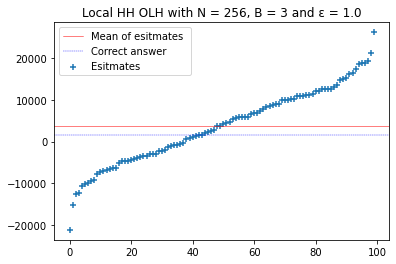

[ 3987.64047938  -106.83358856   958.34725366  4745.00969543
  3047.82691413   337.04370006  5730.17245343   169.9485436
  1175.6260486   1869.70505992   993.1816994   4594.29322572
   123.38621836  1752.27879494  5029.36556261  2374.09709555
   927.99806091  4124.3864431   2200.62325234  2586.37589049
  -601.39117845 -2934.36276635  1738.82303595  5780.00689917
  4407.01443078  3919.18472039  1020.25877163  2771.57761319
  3353.3959138   3423.92874502  4091.79462385  4028.33886487
  -193.56146806  1962.48051765  1096.82109687  3927.80603364
 -1381.517768     923.34725366  2285.64133656  -347.38450401
  3948.15522638  3748.63380494   179.9485436    823.84391644
   325.31582056 -4203.36664452  3757.08956393  -131.48439582
  -167.18278131  1287.88675932   203.91904959  -121.48439582
  4150.59957559   -83.89257658  3669.31410621  1184.24736185
  4086.27987685   942.48331391 -1192.17998504  2323.7479028
  1361.17696405  -222.01722704  2259.07901132  -261.85167278
  3693.7993592  -1491.0211

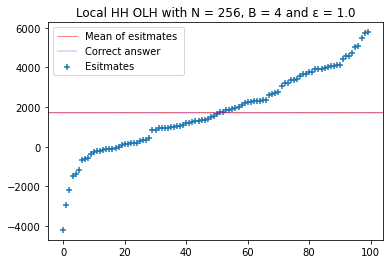

[ 1994.52142144  2198.17890313  3742.91733524 -1094.09150302
  2917.0923602   4034.51582891  1879.50333722  1367.8686751
 -3608.64350038 -2914.04974205  5310.41314084   411.67642309
  -224.81076899  5211.77374337   374.59935085 -4387.39140318
  1307.17028961  2811.21033623  1068.16361517  4383.02584057
  1126.96856691  -629.6994674  -1055.12099703  4777.05059923
  -520.03057592 -1117.54726201    43.16641144  1558.93433755
  5588.39032127  3627.03531127  4029.16663617 -1464.49494843
  4020.03057592  3293.87449236  7461.80431929  3394.24176932
  5505.10011654  3991.92400967    28.68115844 -2153.57395975
  1822.42626498  2789.48245673  1273.71453062  7222.79764485
  -606.94209389  4020.89451566  1620.49666278  -347.07147971
  4874.82605695  2365.7888066   5358.35415282 -2203.40840549
  2385.62325234  2855.53003496  5773.07729697 -1644.69667113
   627.22733854  7866.52746343  1432.18837383  1681.19504827
 -5342.55416118  4279.9011901    830.88482023  3291.11711885
  3731.18945574  -247.568

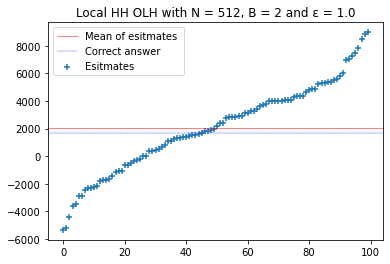

[  6127.97805839   9687.65789804 -23753.15719414  20480.91441066
    208.56180901 -13843.00543724  11083.44375303  15502.25534146
  -7285.87944303  -7460.52689051  18565.85659708 -17073.5797193
  13481.60303755  17193.22110373  12796.5615789   14923.13889985
   -961.29248864  13135.92883457 -12007.41659829  -7304.0022278
  -3380.21405992  -5684.33806939 -24938.72860876  -1089.17964809
  -3577.55957679  -2551.97102416   4372.51599194  -6439.06243865
   3790.67104425    352.28605009  21837.74343671  11425.45854536
 -31309.18352663  -2814.56380279 -13223.20819243  31772.48499399
   5628.98319423  17979.03532771  -3369.78148823   8659.31500414
 -12116.92220367 -11558.6365507   41089.10625082  10967.43151329
 -28887.805171     -113.89436157  17415.48597792  14211.7118402
 -35908.12312414  -8722.48629082 -10707.66621619 -31704.23466268
   2500.060842    -5332.50770642   4272.45401087  -6885.89257381
  11759.90482118  11104.60098172  -1613.14747948   -137.06591791
 -16356.32016906  14795.7106

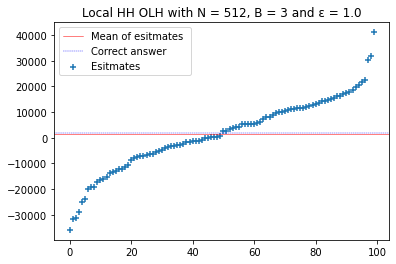

[ -1617.68493618  -8234.48333777   5047.07309959   4274.33865206
   6585.35006781   3569.16652977   7895.7481335   10621.29851694
   6423.84156367   7642.30690573  -2124.97815594  -5589.6872064
   3278.94413938   -415.61690307  -1424.20334259  10253.11649237
    184.01980454   4770.04263604   3029.90022056  -1390.62756208
   5259.74662002  -8192.11293937  -3390.62196955   4517.79333511
   -432.01421201    654.53186168  -4072.20485607   1833.42142323
  -9357.81057408  -3488.55469318   5504.3932299    7735.84232041
  -1347.06523685   5475.21475834   7691.86923096   3397.6714809
  10121.60798823  -2227.71895273   4793.63187182   5240.55469318
   2522.6070008    -264.50570788  11722.22844431   8521.76869478
  -4573.49807582 -13286.62091746  -5706.81185686  14008.04793322
  -7129.15610145   4860.78343284  10316.28150866   7216.95986488
  -3295.07309959  -5092.79129558  11069.82402935  11911.72349317
  -6721.39829638   7025.08096234   -477.1792283   11453.99259865
   6331.49807582   7008.683

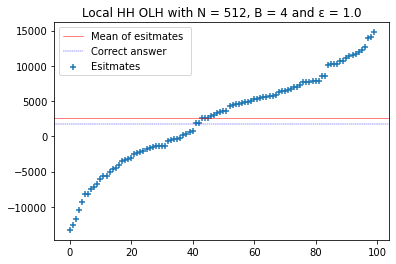

[ 1.11478630e+03 -6.16583752e+02  5.98158629e+03  2.73565939e+03
  9.69116970e+03 -8.49555768e+03  1.20628589e+04 -9.73924022e+02
 -3.77329982e+03 -5.75553633e+02 -1.17545749e+04  9.44834144e+03
 -8.47532482e+02  6.66310117e+03 -1.22342917e+04  6.17727901e+03
  1.41278020e+03 -4.40966324e+02 -3.41386919e+03 -4.22386598e+03
 -6.59852503e+03  3.73436396e+03 -9.50421707e+03  1.03084436e+04
  6.23051996e+03 -1.96355329e+03  1.27805093e+04 -7.19484414e+03
 -3.93830791e+02 -6.92869877e+02  1.57052488e+01  2.37353672e+01
  3.04789512e+02  2.12443150e+02 -7.65745548e+03 -2.22557732e+03
  1.04821364e+04  1.91361743e+03  4.89367089e+03 -1.48383654e+03
  8.65335972e+03  7.15992334e+03 -2.26974297e+03  4.43226229e+02
  5.91437546e+03  1.11877416e+04 -9.10728252e+02  8.25394415e+03
 -8.46343720e+03  1.43774577e+04 -2.19345684e+03  1.04309858e+04
  1.28559159e+04 -6.49749403e+02  5.90931522e+03  1.43895029e+04
 -9.20683074e+02  2.90726176e+03 -9.74969199e+02 -1.13260088e+04
  1.68495233e+04 -4.36736

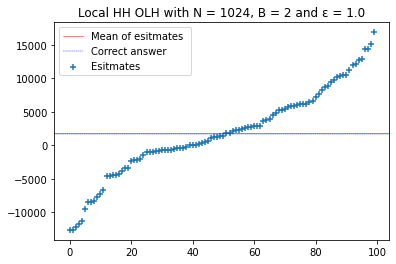

[ 22446.64985049 -58555.37708211 -23508.66542222 -52942.57390556
 -28314.48285809 -26600.40629362  17939.9485695   43502.58381142
 -15655.96246251  22669.55809553 -14938.25624037  58066.31707211
  13669.42590968 -20602.66643436    570.13720187  51655.85564365
 -27587.59266165 -25003.82618182  -4763.76414164  10924.45249978
 -26530.1179389    4885.57180756 -54307.33909035  47079.27826576
  -3706.55341269  -6143.48459183   2138.83909903   5729.33824947
  38413.48026708  34169.41848805 -51681.75885084 -13447.70820749
 -22924.14242223  35350.48162577  65043.79321384  23399.47357336
 -10812.43112548  10208.67624217  27617.54253602 -26083.83061367
   8393.79095452 121625.90182277  -3476.06534119  34350.98531258
  25183.35982074  -4505.26146534 -48171.57490971  -4074.90907167
 -22933.18691928  42292.51904118  -3465.67839442  19059.24461149
 -37810.39553677 -14980.92459575 -22006.17149423  -5559.22518994
  -4212.39614388  40711.36281337 -26186.56700568   -583.89297627
  -2728.94554533 -17823.2

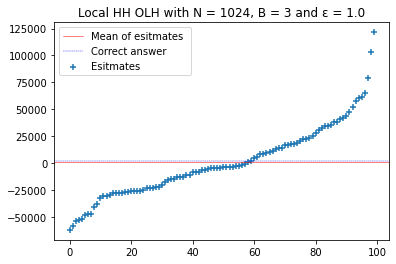

[-11904.14922614   3480.5531797    8614.22617409  16182.44599891
  -5428.0647108   15121.09185205  -2033.71260346  -1844.62831882
   7187.89538477   3335.03122029  -1403.29473324  -5777.05480853
  -8710.47063923  -5354.50238557    511.54811322 -10641.71079464
  10592.23403683   4111.75221255  13374.94943656   9175.88979224
    396.80731642   1024.43056876  11091.92456554  -4376.69710867
  -5061.48537729  -3709.90884004   3110.76846408  11502.4769885
  20479.43836686   7053.18149852 -15588.31295965   5963.84080694
  16846.85041386    431.98578799 -13595.92124323 -22315.04408487
   5647.23456288  -5276.95351561 -18096.79251372  -5087.86923096
  -1322.95124539   2204.92282136   3834.72174899  15944.99131586
  -6918.75244324  29015.47692385   9261.04135326  -6409.85653243
  -1199.82659492  -3385.69990493 -20853.12405977  15719.1258686
  -5221.39119037  22676.11975003  -1988.54758718    380.8207717
   -651.76566782  11990.98904564   1934.67352043  -8563.75675299
  -7735.87074444   1245.8987

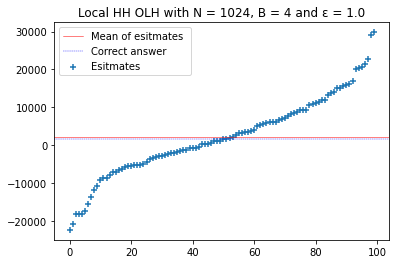

[ 1.57670451e+04 -4.13689894e+03  4.60979968e+03 -2.17927493e+03
 -1.46741238e+04  1.57804037e+03  1.67640423e+04  8.81325664e+03
  1.85569525e+04 -5.76912208e+03 -2.18993536e+04  1.38949835e+04
  1.98901586e+04 -1.48910123e+02  9.00234092e+03 -1.11918255e+04
  1.38402023e+04  2.65813005e+04  1.96914582e+04  1.34300606e+04
 -2.31437920e+04  1.47392668e+04  4.99878146e+02  6.26080399e+03
  5.79588117e+03 -1.27680756e+04  4.83845975e+03 -2.63741659e+03
 -9.19984459e+03  3.96898451e+03 -1.81191443e+03  3.40292358e+03
  1.44370444e+04  1.06193587e+04  3.69515942e+03 -6.79792578e+02
 -8.25240971e+03 -1.57989276e+01 -2.02857450e+03  2.26756686e+04
  8.94398398e+03  3.44145508e+04 -1.10818928e+04 -2.04936912e+03
 -6.08692026e+03  3.61280248e+03  3.85465447e+03 -1.40534855e+03
  1.66069311e+04  6.54543715e+03  1.22879522e+04  6.48066944e+03
 -5.92302790e+03  1.67628504e+04  7.64595631e+03  1.46369367e+04
  6.24880399e+03 -5.83627365e+03 -3.39375373e+03  2.39169017e+04
 -8.58890318e+02  2.52346

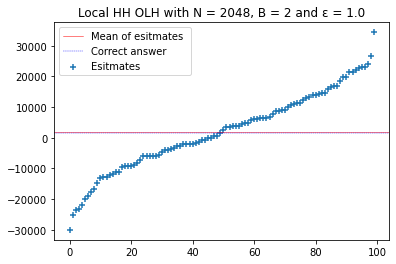

[ 4.37099479e+04 -1.57277955e+04 -1.28603277e+04  5.64746129e+04
 -2.82178355e+04 -1.69308749e+04  3.87068560e+04  9.39947121e+03
  1.41514896e+04 -1.25573524e+04  1.57647216e+05 -3.10013809e+03
  6.39658684e+04  3.53346968e+04  6.69488718e+03  2.21072727e+04
  1.61816477e+04  4.73132412e+04 -4.28439237e+04  1.39630690e+05
  3.40824795e+04  1.34324087e+04  7.64275202e+03 -8.62588858e+04
  1.15586407e+04  6.56336779e+04  5.48934461e+04  6.63199706e+04
  4.86988436e+04 -4.65545657e+03 -1.93705630e+04 -7.40135619e+04
  2.59845478e+04 -4.63992643e+04 -5.23185719e+01  2.63991218e+04
 -4.33472807e+04  1.82541308e+04 -1.40687602e+04 -1.73921182e+04
 -7.08636566e+04 -3.70164585e+04 -2.61912373e+04  1.33458972e+04
  1.71449384e+04  1.67450758e+03  1.14999262e+05  4.23541317e+04
  3.48404872e+04 -9.16886156e+04  5.78773327e+04 -3.94806483e+04
  1.89204428e+04  5.76981027e+03 -5.89508025e+04  1.96591184e+04
  4.34850012e+04  1.45804195e+05 -4.21023843e+04  5.67968563e+04
 -1.09375003e+05 -7.33080

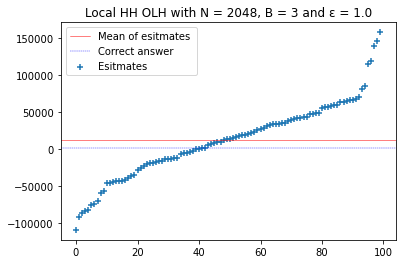

In [ ]:
epsilons = np.array([2,1.4,1.2,1,0.8,0.3])
n = np.array([32,128,256,512,1024,2048])
degrees = np.array([2,3,4])
number_of_qurries = 100
range_dates = ('2014-01-02','2014-01-9')   

for e in epsilons:
    for N in n:
        for degree in degrees:
            plot_name = 'plots/local_hh_freq/' + f'local_e={e}_N={N}_B={degree}.png'
            csv_name = 'results/local_hh_freq/' + f'local_e={e}_N={N}_B={degree}.csv'
            answers = plot_estimates_hh_degree(number_of_qurries, N, HH_OLH_degree, e, degree, all_dates, all_counts, range_dates, plot_name)
            np.savetxt(csv_name, answers, delimiter=',')


In [21]:
epsilons = np.array([2,1.4,1.2,1,0.8,0.3])
n = np.array([32,128,256,512,1024,2048])
degrees = np.array([2,3,4])
n_range_qurries = 100
#range_query_length = 20
for e in epsilons:
    for N in n:
        range_query_length = int(N//2)
        for degree in degrees:
            range_qurries = [] 
            for i in range(0, n_range_qurries):
                range_qurries.append(sample_range_query(range_query_length, all_dates[:N]))
                
            correct_name = 'results/local_hh_freq_fixed_model/' + f'correct_answers_local_e={e}_N={N}_B={degree}.csv'
            csv_name = 'results/local_hh_freq_fixed_model/' + f'answers_local_e={e}_N={N}_B={degree}.csv'
            answers, correct_answers = plot_estimates_hh_degree_mutiplee_qurries(range_qurries, N, HH_OLH_degree, e, degree, all_dates, all_counts)
            np.savetxt(csv_name, answers, delimiter=',')
            np.savetxt(correct_name, correct_answers, delimiter=',')

Benefit over flat

In [103]:
D = 64
b = 2
#r = 10
h = int(np.ceil(np.log(D) / np.log(b)))
alpha = (np.log(r) / np.log(b))
print(2*b*(np.log(D) / np.log(b))**2)


144.0


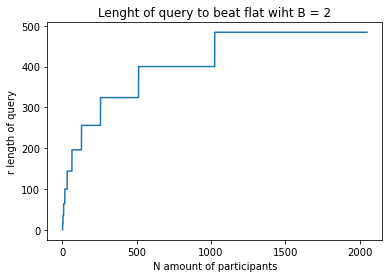

In [293]:
def myfunc_dis(x):
    return 2*b*int(np.ceil(np.log(x) / np.log(b)))**2

def myfunc_cont(x):
    return 2*b*(np.log(x) / np.log(b))**2

def plot_flat_vs_hh(b):
    xs = np.linspace(1,2048,10000)
    f2 = np.vectorize(myfunc_dis)
    plt.plot(xs,f2(xs))
    plt.xlabel("N amount of participants")
    plt.ylabel("r length of query")
    plt.title(f"Lenght of query to beat flat wiht B = {b}")

plot_flat_vs_hh(b)


[1.00000000e+00 1.20472047e+00 1.40944094e+00 ... 2.04759056e+03
 2.04779528e+03 2.04800000e+03]


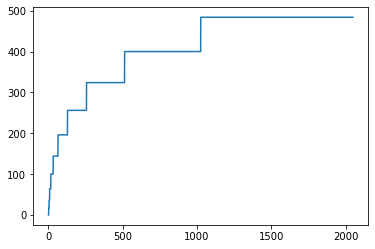

In [107]:
def cal_lenght_of_range(D, b)
    h = int(np.ceil(np.log(D) / np.log(b)))
    alpha = (np.log(r) / np.log(b))
    return 2*b*(np.log(D) / np.log(b))**2

In [14]:
def sample_range_query(length, dates):
    while True:
        start_date_idx = np.random.randint((dates[-1]-dates[0]).days+1)
        start_date = dates[start_date_idx]
        end_date = dates[start_date_idx] + timedelta(days=(length-1))
        if dates[-1] > end_date:
            return (str(start_date), str(end_date))
length = 10
print(all_dates[:2])
a = sample_range_query(length, all_dates[:32])

[datetime.date(2014, 1, 2), datetime.date(2014, 1, 3)]


In [270]:
local_HH.answer(a)

9
18
level_offset = 1
Counting nodes
At level 1
Both not zero
[]
At level 2
At level 3
Right not zero
3
At level 4
Both not zero
8
5
At level 5
Both not zero
18
9


In [ ]:
def max_disjoint_B_adic_ranges(r, B):
    # r = length, B = log base
    #Fact 3
    #Any sub-range of length[a,b]of length r from [D] can be decomposed into ≤ (B−1)(2 logBr+1)disjoint B-adic ranges.
    #(B−1)(2 logBr+1)
    return (B-1)*(2* np.log(r+1) / np.log(B))

In [ ]:
B = 2
r = 20
print(max_disjoint_B_adic_ranges(r,B))
n = 74088
exp = 42
np.log(n) / np.log(exp)